# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv",sep=";")
#import io

#from google.colab import files
#uploaded = files.upload()

#azdias=pd.read_csv(io.BytesIO(uploaded["Udacity_AZDIAS_Subset.csv"]),sep=";")

In [3]:

#from google.colab import files
#uploaded_feat = files.upload()

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv",sep=";")
#pd.read_csv(io.BytesIO(uploaded_feat["AZDIAS_Feature_Summary.csv"]),sep=";")

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(f'Udacity AZDIAS Subset has {azdias.shape[0]} rows, {azdias.shape[1]} columns')
print(azdias.head())

print(f'AZDIAS_Feature_Summary has {feat_info.shape[0]} rows, {feat_info.shape[1]} columns')
print(feat_info.head())

Udacity AZDIAS Subset has 891221 rows, 85 columns
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...   

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [6]:
for f in range(len(feat_info)): 
    missing_or_unknown_values = feat_info.iloc[f]['missing_or_unknown'] 
    missing_or_unknown_values = missing_or_unknown_values.strip(']') 
    missing_or_unknown_values = missing_or_unknown_values.strip('[') 
    missing_or_unknown_values = missing_or_unknown_values.split(sep=',') 
    missing_or_unknown_values = [int(value) if (value!='' and value!='X' and value!='XX') else value for value in missing_or_unknown_values] 
    
    if missing_or_unknown_values != ['']:
      azdias = azdias.replace({feat_info.iloc[f]['attribute']: missing_or_unknown_values}, np.nan)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing_data_cols=azdias.isnull().sum()[azdias.isnull().sum()>0].sort_values(ascending=False)
missing_data_cols

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
CAMEO_DE

In [8]:
#!pip install missingno

In [9]:
!pip install missingno

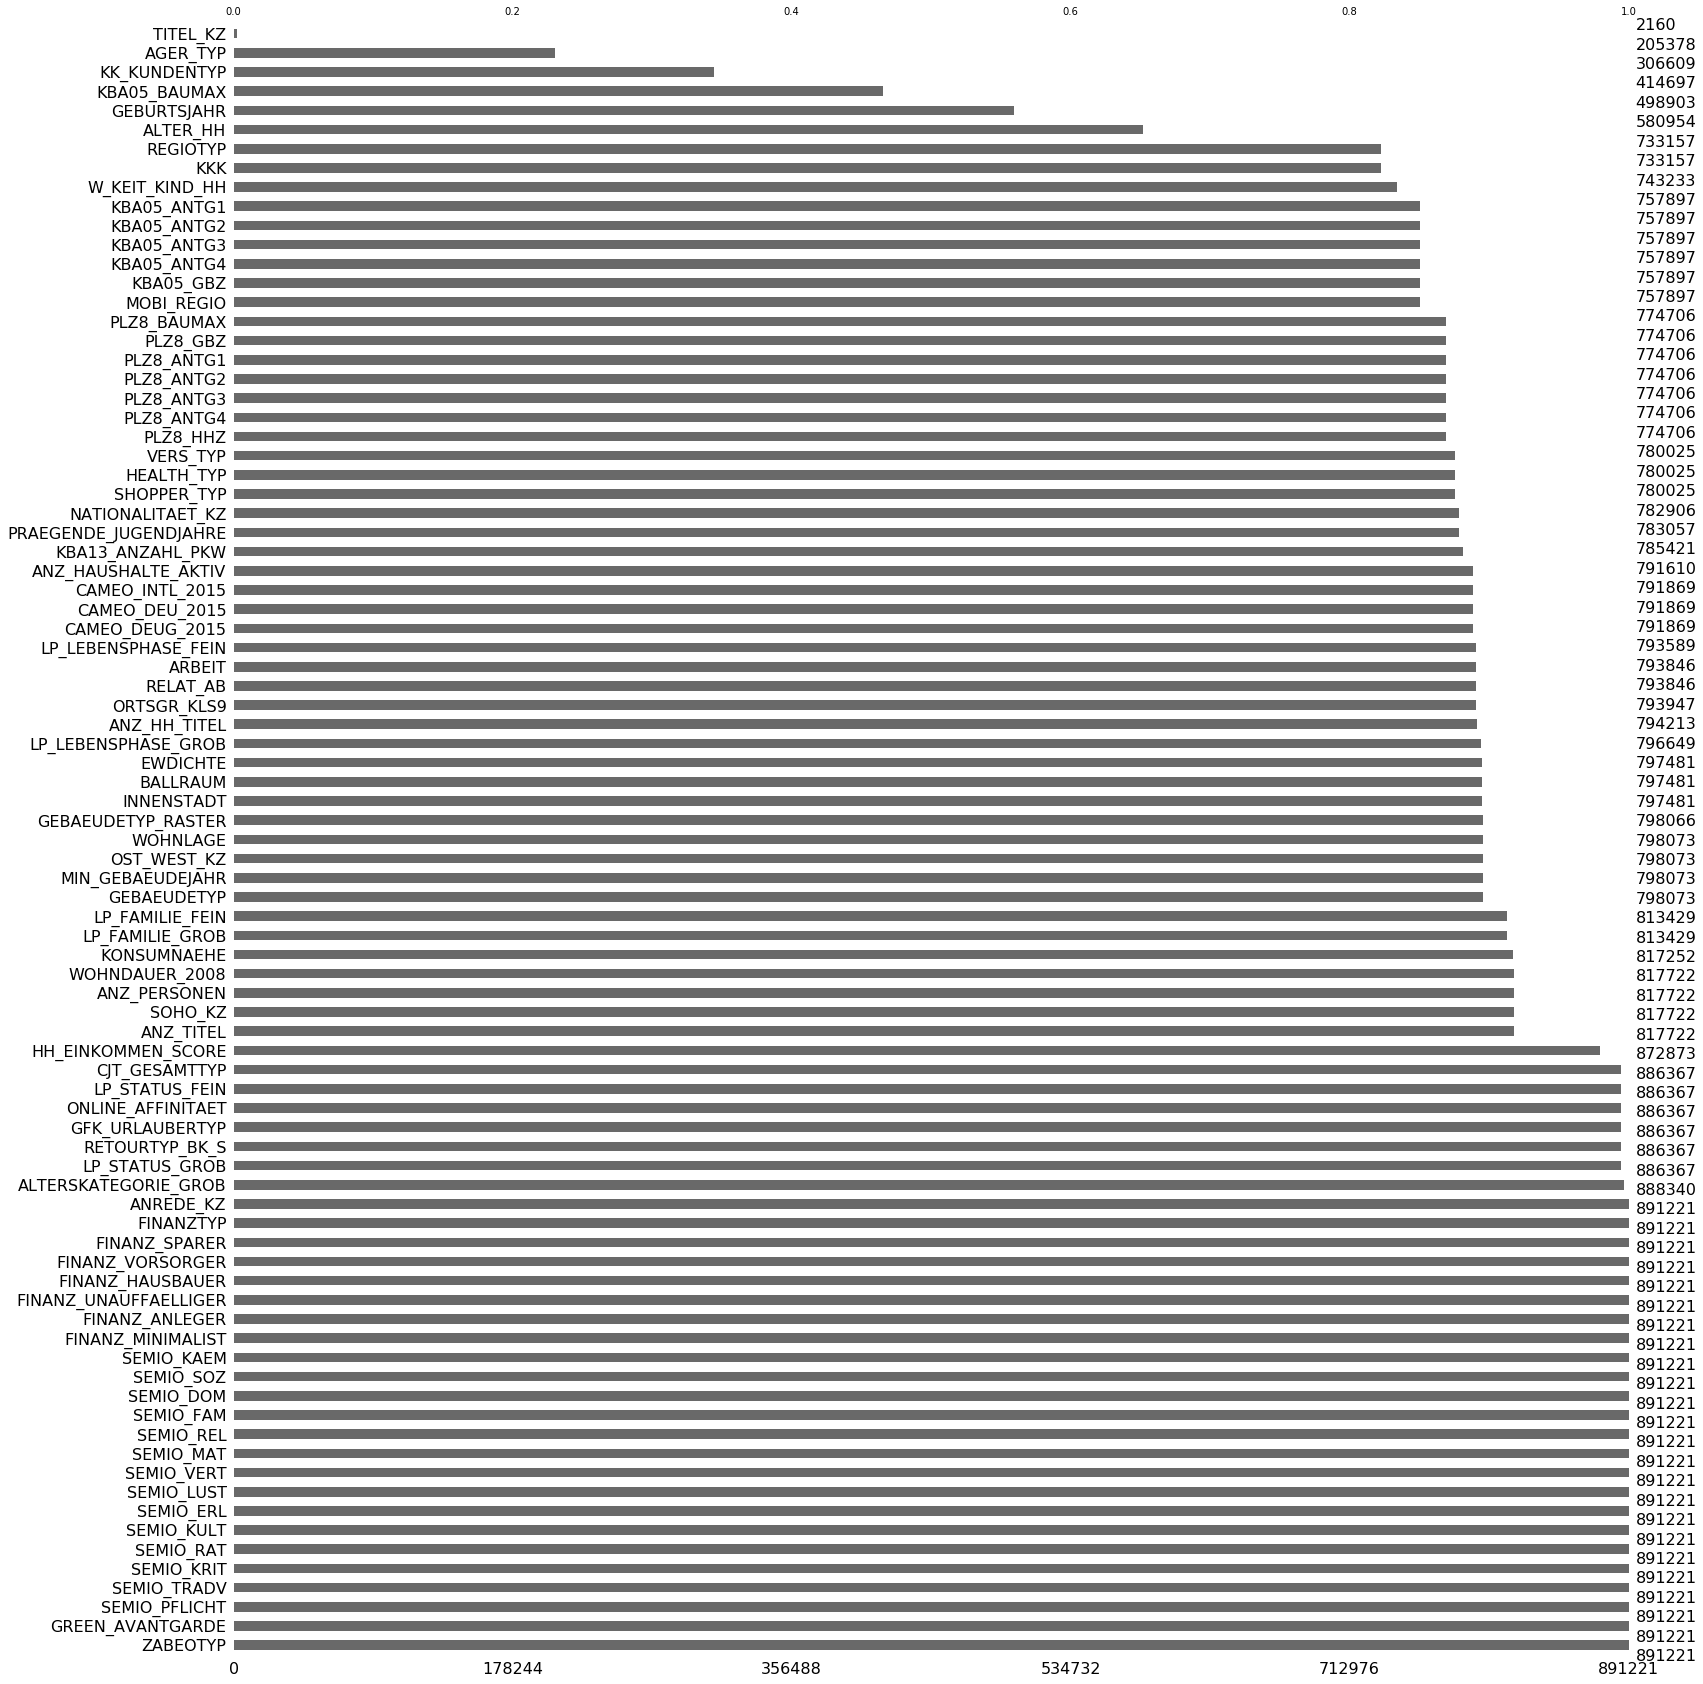

In [10]:
import missingno as msno

msno.bar(azdias,sort="descending")

As seen above 	TITEL_KZ is missing lots of values with only 2160 values present thus less than 0.24% data available, followed by AGER_TYP,

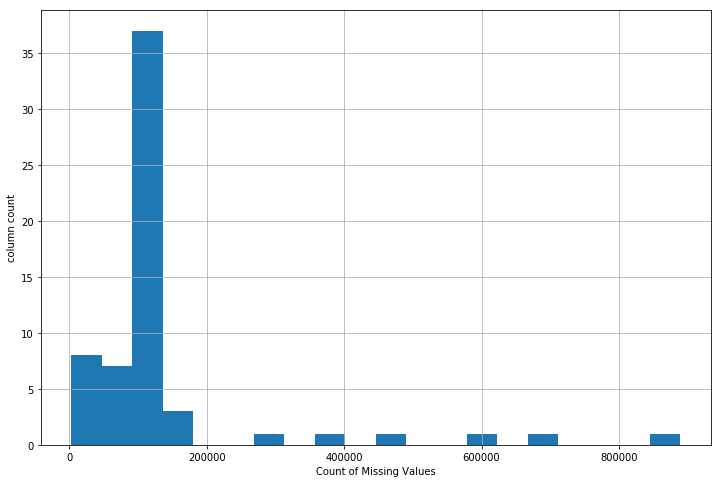

In [11]:
# Investigate patterns in the amount of missing data in each column.

plt.figure(figsize=(12,8))
plt.hist(missing_data_cols.transpose(),bins=20)
plt.xlabel("Count of Missing Values")
plt.ylabel("column count")
plt.grid(True)
plt.show()

As seen from Above, only 6 columns seems to be outlier here. As the number of missing values are greater than 200,000.

In [12]:
missing_data_cols=pd.DataFrame(missing_data_cols).transpose()
missing_data_cols

,TITEL_KZ,AGER_TYP,KK_KUNDENTYP,KBA05_BAUMAX,GEBURTSJAHR,ALTER_HH,REGIOTYP,KKK,W_KEIT_KIND_HH,KBA05_ANTG4,...,SOHO_KZ,ANZ_PERSONEN,HH_EINKOMMEN_SCORE,LP_STATUS_GROB,LP_STATUS_FEIN,RETOURTYP_BK_S,ONLINE_AFFINITAET,GFK_URLAUBERTYP,CJT_GESAMTTYP,ALTERSKATEGORIE_GROB
0,889061,685843,584612,476524,392318,310267,158064,158064,147988,133324,...,73499,73499,18348,4854,4854,4854,4854,4854,4854,2881


In [13]:
filter=(missing_data_cols>200000).any()
outlier_cols=missing_data_cols.loc[: , filter]
outlier_cols

,TITEL_KZ,AGER_TYP,KK_KUNDENTYP,KBA05_BAUMAX,GEBURTSJAHR,ALTER_HH
0,889061,685843,584612,476524,392318,310267


In [14]:
list(outlier_cols.columns)

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [15]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias=azdias.drop(list(outlier_cols.columns),axis=1)
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

* 79 columns has at least 80% non-missing data in them.
* 24 colums has no missing values
* About 6 Columns where outliers with over 200,000 missing values thus more than 22.4% of the original data missing.This is about 7% of the columns.

The 6 Columns removed from the dataset where:
* 'TITEL_KZ',
* 'AGER_TYP',
* 'KK_KUNDENTYP',
* 'KBA05_BAUMAX',
* 'GEBURTSJAHR',
* 'ALTER_HH'

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [16]:
# How much data is missing in each row of the dataset?

azdias.isnull().sum(axis=1).sort_values(ascending=False)

643174    49
732775    49
472919    48
183108    47
139316    47
691141    47
691142    47
691171    47
691183    47
139332    47
691197    47
139323    47
691212    47
691122    47
139267    47
139255    47
139250    47
139248    47
139245    47
139243    47
691317    47
691129    47
691118    47
139236    47
139478    47
690871    47
690876    47
690878    47
690887    47
139521    47
          ..
540246     0
540244     0
540243     0
540242     0
540241     0
540240     0
540239     0
540269     0
540271     0
540300     0
540289     0
540299     0
540298     0
540296     0
540295     0
540293     0
540292     0
540291     0
540290     0
540287     0
540273     0
540286     0
540284     0
540283     0
540281     0
540280     0
540277     0
540275     0
540274     0
445610     0
Length: 891221, dtype: int64

In [17]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
few_missing_values= azdias[azdias.isnull().sum(axis=1)<6]
many_missing_values= azdias[azdias.isnull().sum(axis=1)>=6]

print(f'few missing value shape{few_missing_values.shape}')
print(f'many missing value shape{many_missing_values.shape}')

few missing value shape(719624, 79)
many missing value shape(171597, 79)


In [18]:
# checking for only clean columns
clean_columns=pd.DataFrame(azdias.isnull().sum()[azdias.isnull().sum()==0]).transpose()
clean_columns.columns

Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'ZABEOTYP'],
      dtype='object')

I am taking first 5 columns

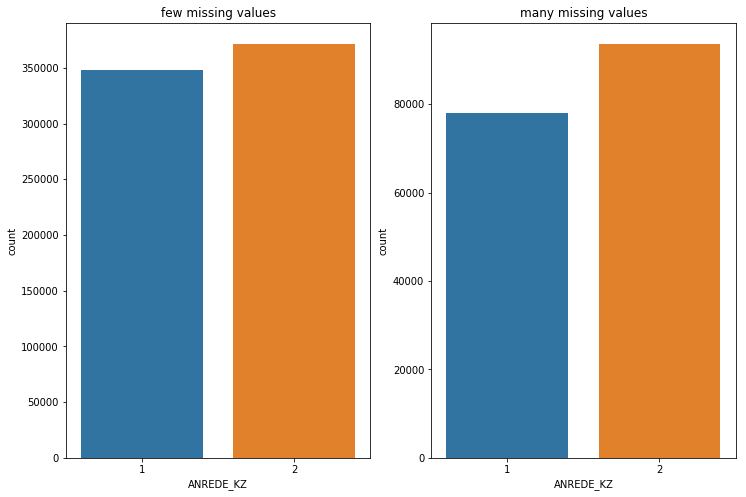

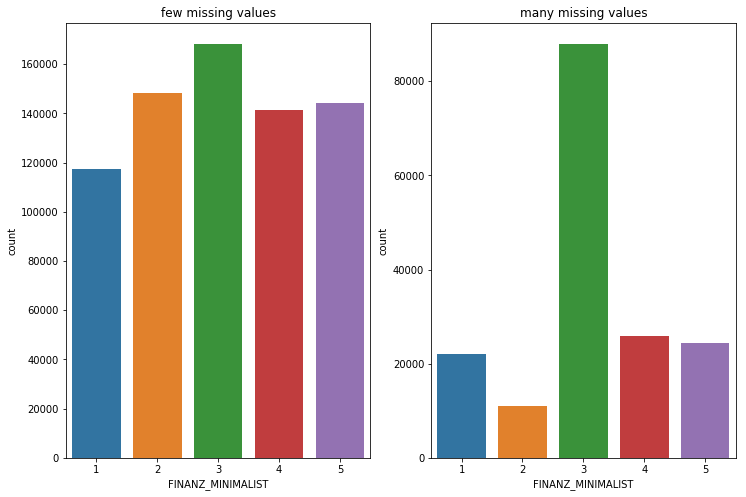

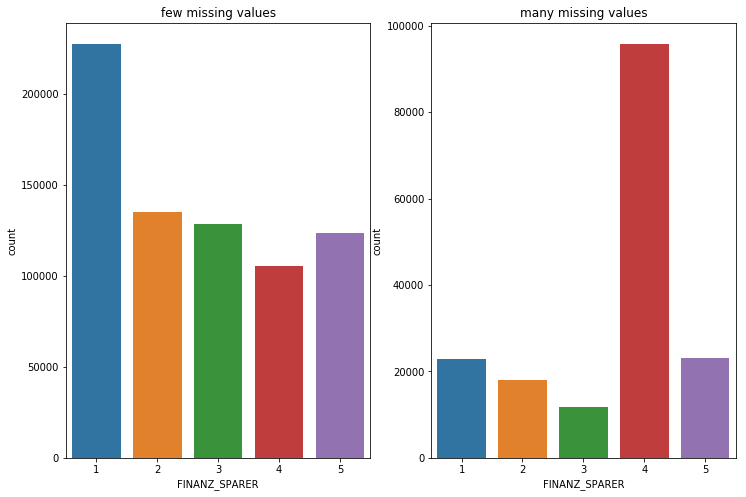

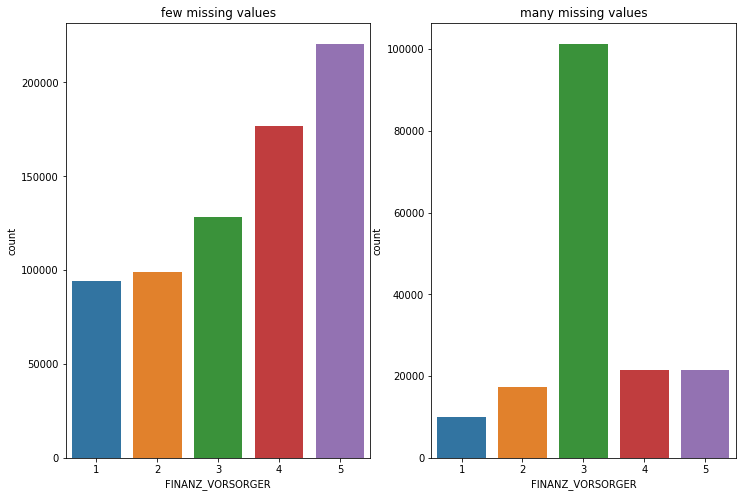

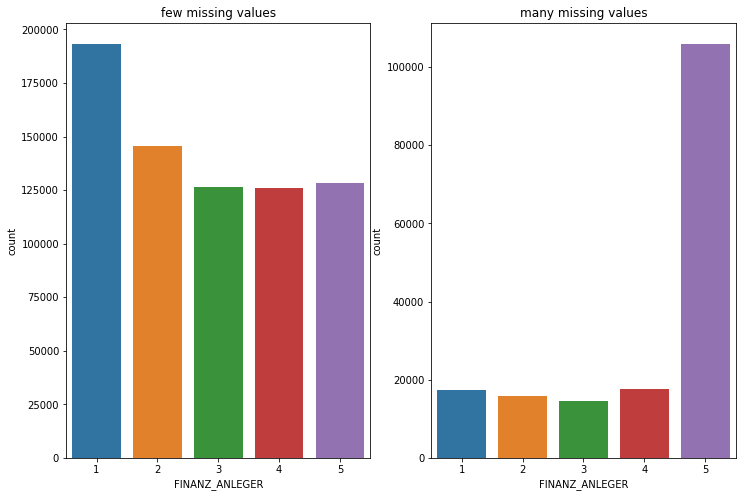

In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_dist(col_name):
    fig =plt.figure(figsize=(12,8))
    axis1=fig.add_subplot(121)
    axis1.title.set_text('few missing values')
    sns.countplot(x=col_name,data=few_missing_values)

    axis2=fig.add_subplot(122)
    axis2.title.set_text('many missing values')
    sns.countplot(x=col_name,data=many_missing_values)


first_five_col=['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER']

for col in first_five_col:
    compare_dist(col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Data with lots of missing values are qualitatively different from data with few or no missing values. You can notice this from the graph comparison above. This shows that the missing data is special. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [20]:
# How many features are there of each data type?

feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [21]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

cat_vars=list(feat_info[feat_info['type']=='categorical']['attribute'])

for item in cat_vars:   
    if item in ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR',
 'ALTER_HH']:
        cat_vars.remove(item)
cat_vars

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

3 of the deleted outlier columns was removed from the list

In [22]:
print(f'There are now {len(cat_vars)} categorical variables after deletion')

There are now 18 categorical variables after deletion


In [23]:
# No of unique values in each categorical columns.
cat_vars=pd.DataFrame(azdias[cat_vars].nunique()).transpose()
cat_vars

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
0,2,6,6,12,2,11,5,10,5,3,4,2,2,6,7,2,9,44


In [24]:
azdias[list(cat_vars.columns)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 18 columns):
ANREDE_KZ           891221 non-null int64
CJT_GESAMTTYP       886367 non-null float64
FINANZTYP           891221 non-null int64
GFK_URLAUBERTYP     886367 non-null float64
GREEN_AVANTGARDE    891221 non-null int64
LP_FAMILIE_FEIN     813429 non-null float64
LP_FAMILIE_GROB     813429 non-null float64
LP_STATUS_FEIN      886367 non-null float64
LP_STATUS_GROB      886367 non-null float64
NATIONALITAET_KZ    782906 non-null float64
SHOPPER_TYP         780025 non-null float64
SOHO_KZ             817722 non-null float64
VERS_TYP            780025 non-null float64
ZABEOTYP            891221 non-null int64
GEBAEUDETYP         798073 non-null float64
OST_WEST_KZ         798073 non-null object
CAMEO_DEUG_2015     791869 non-null object
CAMEO_DEU_2015      791869 non-null object
dtypes: float64(11), int64(4), object(3)
memory usage: 122.4+ MB


In [25]:
#binary column info
azdias[['ANREDE_KZ','GREEN_AVANTGARDE','SOHO_KZ','VERS_TYP','OST_WEST_KZ']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 5 columns):
ANREDE_KZ           891221 non-null int64
GREEN_AVANTGARDE    891221 non-null int64
SOHO_KZ             817722 non-null float64
VERS_TYP            780025 non-null float64
OST_WEST_KZ         798073 non-null object
dtypes: float64(2), int64(2), object(1)
memory usage: 34.0+ MB


Binary variable 'OST_WEST_KZ' is of type object, so we need to convert it to integer.

In [26]:
azdias['OST_WEST_KZ'].unique()

array([nan, 'W', 'O'], dtype=object)

In [27]:
# OST_WEST_KZ needs re-encoding.
azdias['OST_WEST_KZ']=azdias['OST_WEST_KZ'].map({'W':0,'O':1})
azdias['OST_WEST_KZ'].unique()

array([ nan,   0.,   1.])

In [28]:
azdias[['OST_WEST_KZ']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 1 columns):
OST_WEST_KZ    798073 non-null float64
dtypes: float64(1)
memory usage: 6.8 MB


In [29]:
cat_vars[cat_vars['CJT_GESAMTTYP']>2]

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
0,2,6,6,12,2,11,5,10,5,3,4,2,2,6,7,2,9,44


In [30]:
## Mixed variables
mixed_var=list(feat_info[feat_info['type']=='mixed']['attribute'])
mixed_var

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [31]:
mixed_var=['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015','PLZ8_BAUMAX'] #exclude 'KBA05_BAUMAX'

azdias[mixed_var].nunique()

LP_LEBENSPHASE_FEIN      40
LP_LEBENSPHASE_GROB      12
PRAEGENDE_JUGENDJAHRE    15
WOHNLAGE                  8
CAMEO_INTL_2015          21
PLZ8_BAUMAX               5
dtype: int64

In [32]:
azdias[mixed_var].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 6 columns):
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
PRAEGENDE_JUGENDJAHRE    783057 non-null float64
WOHNLAGE                 798073 non-null float64
CAMEO_INTL_2015          791869 non-null object
PLZ8_BAUMAX              774706 non-null float64
dtypes: float64(5), object(1)
memory usage: 40.8+ MB


In [33]:
azdias['CAMEO_INTL_2015'].nunique()

21

In [34]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_clean=pd.get_dummies(azdias,columns=['CAMEO_DEUG_2015','CAMEO_DEU_2015'])
encoded=list(azdias_clean.columns)

print("{} total features after one-hot encoding.".format(len(encoded)))

#print(encoded)

130 total features after one-hot encoding.


#### Discussion 1.2.1: Re-Encode Categorical Features

There where about 5 binary variables, of which the variable 'OST_WEST_KZ' needed to be re-encoded.

I performed One hotencoding on Categorical variables, like CAMEO_DEUG_2015,CAMEO_DEU_2015 and Mixed variable like CAMEO_INT_2015.

These steps brings to a total of 130 features.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [35]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias_clean['PRAEGENDE_JUGENDJAHRE'].describe()

count    783057.000000
mean          9.280709
std           4.032107
min           1.000000
25%           6.000000
50%           9.000000
75%          14.000000
max          15.000000
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [36]:
print(azdias_clean['PRAEGENDE_JUGENDJAHRE'].unique())

[ nan  14.  15.   8.   3.  10.  11.   5.   9.   6.   4.   2.   1.  12.  13.
   7.]


In [37]:
azdias_clean['PRAEGENDE_JUGENDJAHRE_DECADE']=azdias_clean['PRAEGENDE_JUGENDJAHRE'].map({1:40,2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90})
azdias_clean['PRAEGENDE_JUGENDJAHRE_DECADE']

0          NaN
1         90.0
2         90.0
3         70.0
4         70.0
5         50.0
6         80.0
7         70.0
8         80.0
9         90.0
10        50.0
11         NaN
12        70.0
13        90.0
14         NaN
15        60.0
16        90.0
17         NaN
18        80.0
19        70.0
20        80.0
21        80.0
22        90.0
23        70.0
24         NaN
25        90.0
26        70.0
27        80.0
28        80.0
29        60.0
          ... 
891191    50.0
891192    90.0
891193    60.0
891194    80.0
891195    70.0
891196    90.0
891197    80.0
891198    90.0
891199    80.0
891200    90.0
891201    80.0
891202    80.0
891203     NaN
891204    80.0
891205    50.0
891206    90.0
891207    40.0
891208    70.0
891209    90.0
891210    70.0
891211    70.0
891212    50.0
891213    80.0
891214    90.0
891215    80.0
891216    90.0
891217    80.0
891218    90.0
891219    90.0
891220    50.0
Name: PRAEGENDE_JUGENDJAHRE_DECADE, Length: 891221, dtype: float64

If Mainstream then 0, If Avantgarde then 1, signifying movement of person's youth.

In [38]:
azdias_clean['PRAEGENDE_JUGENDJAHRE_MOVEMENT']=azdias_clean['PRAEGENDE_JUGENDJAHRE'].replace([1,3,5,8,10,12,14],0)
azdias_clean['PRAEGENDE_JUGENDJAHRE_MOVEMENT']=azdias_clean['PRAEGENDE_JUGENDJAHRE'].replace([2,4,6,7,9,11,13,15],1)
azdias_clean['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].head()

0     NaN
1    14.0
2     1.0
3     8.0
4     8.0
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: float64

In [39]:
azdias_clean=azdias_clean.drop('PRAEGENDE_JUGENDJAHRE',axis=1)
azdias_clean

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT
0,2.0,1,2.0,3,4,3,5,5,3,4,...,0,0,0,0,0,0,0,0,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,0,0,0,0,0,0,0,0,90.0,14.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,0,0,0,0,0,0,0,0,90.0,1.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,0,0,0,0,0,0,0,0,70.0,8.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,0,0,0,0,0,0,0,0,70.0,8.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,0,1,0,0,0,0,0,0,50.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,0,0,0,0,0,0,0,0,80.0,10.0
7,1.0,1,3.0,3,3,4,1,3,2,5,...,0,0,0,0,0,0,0,0,70.0,8.0
8,3.0,1,3.0,4,4,2,4,2,2,6,...,0,0,0,0,0,0,0,0,80.0,1.0
9,3.0,2,4.0,2,4,2,3,5,4,1,...,0,0,0,0,0,0,0,0,90.0,1.0


In [40]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias_clean['CAMEO_INTL_2015']=azdias['CAMEO_INTL_2015'].astype('float')
azdias_clean['CAMEO_INTL_2015'].unique()

array([ nan,  51.,  24.,  12.,  43.,  54.,  22.,  14.,  13.,  15.,  33.,
        41.,  34.,  55.,  25.,  23.,  31.,  52.,  35.,  45.,  44.,  32.])

5 being the most wealthy  and 1 least.

In [41]:
''' 
azdias_clean['CAMEO_INTL_2015_WEALTH']=azdias_clean['CAMEO_INTL_2015'].replace([11,12,13,14,15],5)
azdias_clean['CAMEO_INTL_2015_WEALTH']=azdias_clean['CAMEO_INTL_2015'].replace([21,22,23,24,25],4)
azdias_clean['CAMEO_INTL_2015_WEALTH']=azdias_clean['CAMEO_INTL_2015'].replace([31,32,33,34,35],3)
azdias_clean['CAMEO_INTL_2015_WEALTH']=azdias_clean['CAMEO_INTL_2015'].replace([41,42,43,44,45],2)
azdias_clean['CAMEO_INTL_2015_WEALTH']=azdias_clean['CAMEO_INTL_2015'].replace([51,52,53,54,55],1)
azdias_clean['CAMEO_INTL_2015_WEALTH'].head()
'''

" \nazdias_clean['CAMEO_INTL_2015_WEALTH']=azdias_clean['CAMEO_INTL_2015'].replace([11,12,13,14,15],5)\nazdias_clean['CAMEO_INTL_2015_WEALTH']=azdias_clean['CAMEO_INTL_2015'].replace([21,22,23,24,25],4)\nazdias_clean['CAMEO_INTL_2015_WEALTH']=azdias_clean['CAMEO_INTL_2015'].replace([31,32,33,34,35],3)\nazdias_clean['CAMEO_INTL_2015_WEALTH']=azdias_clean['CAMEO_INTL_2015'].replace([41,42,43,44,45],2)\nazdias_clean['CAMEO_INTL_2015_WEALTH']=azdias_clean['CAMEO_INTL_2015'].replace([51,52,53,54,55],1)\nazdias_clean['CAMEO_INTL_2015_WEALTH'].head()\n"

In [42]:
wealth=[]
life_stage=[]
for values in list(azdias_clean['CAMEO_INTL_2015']):
    if values in [11,12,13,14,15]:
        wealth.append(5)

    elif values in [21,22,23,24,25]:
        wealth.append(4)
    elif values in [31,32,33,34,35]:
        wealth.append(3)
    elif values in [41,42,43,44,45]:
        wealth.append(2)
    elif values in [51,52,53, 54, 55]:
        wealth.append(1)
    else:
        wealth.append(np.nan)

In [43]:
azdias_clean[['CAMEO_INTL_2015']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 1 columns):
CAMEO_INTL_2015    791869 non-null float64
dtypes: float64(1)
memory usage: 6.8 MB


In [44]:
for values in list(azdias_clean['CAMEO_INTL_2015']):
    if values in [11,21,31,41,51]:
        life_stage.append(1)
    elif values in [12,22,32,42,52]:
        life_stage.append(2)
    elif values in [13,23,33,43,53]:
        life_stage.append(3)
    elif values in [14,24,34,44,54]:
        life_stage.append(4)
    elif values in [15,25,35,45,55]:
        life_stage.append(5)
    else:
        life_stage.append(np.nan)

In [45]:
azdias_clean['CAMEO_INTL_2015_WEALTH']=np.array(wealth)
azdias_clean['CAMEO_INTL_2015_WEALTH'].head()

0    NaN
1    1.0
2    4.0
3    5.0
4    2.0
Name: CAMEO_INTL_2015_WEALTH, dtype: float64

In [46]:
azdias_clean['CAMEO_INTL_2015_LIFE_STAGE']=np.array(life_stage)
azdias_clean['CAMEO_INTL_2015_LIFE_STAGE'].head()

0    NaN
1    1.0
2    4.0
3    2.0
4    3.0
Name: CAMEO_INTL_2015_LIFE_STAGE, dtype: float64

In [47]:
azdias_clean=azdias_clean.drop('CAMEO_INTL_2015',axis=1)
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,2.0,1,2.0,3,4,3,5,5,3,4,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,0,0,0,0,0,0,90.0,14.0,1.0,1.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,0,0,0,0,0,0,90.0,1.0,4.0,4.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,0,0,0,0,0,0,70.0,8.0,5.0,2.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,0,0,0,0,0,0,70.0,8.0,2.0,3.0


In [48]:
azdias_clean[['PRAEGENDE_JUGENDJAHRE_DECADE','PRAEGENDE_JUGENDJAHRE_MOVEMENT','CAMEO_INTL_2015_WEALTH','CAMEO_INTL_2015_LIFE_STAGE']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 4 columns):
PRAEGENDE_JUGENDJAHRE_DECADE      783057 non-null float64
PRAEGENDE_JUGENDJAHRE_MOVEMENT    783057 non-null float64
CAMEO_INTL_2015_WEALTH            791869 non-null float64
CAMEO_INTL_2015_LIFE_STAGE        791869 non-null float64
dtypes: float64(4)
memory usage: 27.2 MB


#### Discussion 1.2.2: Engineer Mixed-Type Features

I splitted 'PRAEGENDE_JUGENDJAHRE' into 'PRAEGENDE_JUGENDJAHRE_DECADE' and 'PRAEGENDE_JUGENDJAHRE_MOVEMENT' through mapping some values to them.

I also splitted 'CAMEO_INTL_2015' into 'CAMEO_INTL_2015_WEALTH' and 'CAMEO_INTL_2015_LIFE_STAGE' by mapping values from 'CAMEO_INTL_2015' to them. 

I dropped ´PRAEGENDE_JUGENDJAHRE´ and ´CAMEO_INTL_2015´

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [49]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [50]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias_clean.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP',
       ...
       'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A', 'CAMEO_DEU_2015_9B',
       'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E',
       'PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT',
       'CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFE_STAGE'],
      dtype='object', length=132)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [51]:
def clean_data(azdias):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    for f in range(len(feat_info)): 
        missing_or_unknown_values = feat_info.iloc[f]['missing_or_unknown'] 
        missing_or_unknown_values = missing_or_unknown_values.strip(']') 
        missing_or_unknown_values = missing_or_unknown_values.strip('[') 
        missing_or_unknown_values = missing_or_unknown_values.split(sep=',') 
        missing_or_unknown_values = [int(value) if (value!='' and value!='X' and value!='XX') else value for value in missing_or_unknown_values] 
    
    if missing_or_unknown_values != ['']:
       azdias = azdias.replace({feat_info.iloc[f]['attribute']: missing_or_unknown_values}, np.nan)
    
    # remove selected columns and rows, ...
    missing_data_cols=azdias.isnull().sum()[azdias.isnull().sum()>0].sort_values(ascending=False)
    missing_data_cols=pd.DataFrame(missing_data_cols).transpose()
    filter=(missing_data_cols>200000).any()
    outlier_cols=missing_data_cols.loc[: , filter]
    azdias=azdias.drop(list(outlier_cols.columns),axis=1)
    
    # select, re-encode, and engineer column values.
    cat_vars=list(feat_info[feat_info['type']=='categorical']['attribute'])

    for item in cat_vars:
        if item in ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']:
           cat_vars.remove(item)
    cat_vars=pd.DataFrame(azdias[cat_vars].nunique()).transpose()
    azdias['OST_WEST_KZ']=azdias['OST_WEST_KZ'].map({'W':0,'O':1})
    mixed_var=list(feat_info[feat_info['type']=='mixed']['attribute'])
    mixed_var=['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','PRAEGENDE_JUGENDJAHRE','WOHNLAGE','CAMEO_INTL_2015','PLZ8_BAUMAX']
    azdias_clean=pd.get_dummies(azdias,columns=['CAMEO_DEUG_2015','CAMEO_DEU_2015'])
    azdias_clean['PRAEGENDE_JUGENDJAHRE']=azdias['PRAEGENDE_JUGENDJAHRE'].map({1:40,2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90})
    #azdias_clean['PRAEGENDE_JUGENDJAHRE_DECADE']=azdias['PRAEGENDE_JUGENDJAHRE']
    azdias_clean['PRAEGENDE_JUGENDJAHRE_MOVEMENT']=azdias_clean['PRAEGENDE_JUGENDJAHRE'].replace([1,3,5,8,10,12,14],0)
    azdias_clean['PRAEGENDE_JUGENDJAHRE_MOVEMENT']=azdias_clean['PRAEGENDE_JUGENDJAHRE'].replace([2,4,6,7,9,11,13,15],1)
    azdias_clean=azdias_clean.drop('PRAEGENDE_JUGENDJAHRE',axis=1)
    #azdias_clean['CAMEO_INTL_2015']=azdias_clean['CAMEO_INTL_2015'].astype('float')

    wealth=[]
    life_stage=[]
    for values in list(azdias_clean['CAMEO_INTL_2015']):
        if values in [11,12,13,14,15]:
            wealth.append(5)

        elif values in [21,22,23,24,25]:
            wealth.append(4)
        elif values in [31,32,33,34,35]:
            wealth.append(3)
        elif values in [41,42,43,44,45]:
            wealth.append(2)
        elif values in [51,52,53, 54, 55]:
            wealth.append(1)
        else:
            wealth.append(np.nan)



    for values in list(azdias_clean['CAMEO_INTL_2015']):
        if values in [11,21,31,41,51]:
            life_stage.append(1)
        elif values in [12,22,32,42,52]:
            life_stage.append(2)
        elif values in [13,23,33,43,53]:
            life_stage.append(3)
        elif values in [14,24,34,44,54]:
            life_stage.append(4)
        elif values in [15,25,35,45,55]:
            life_stage.append(5)
        else:
            life_stage.append(np.nan)

    azdias_clean['CAMEO_INTL_2015_WEALTH']=np.array(wealth)
    azdias_clean['CAMEO_INTL_2015_LIFE_STAGE']=np.array(life_stage)
    azdias_clean=azdias_clean.drop('CAMEO_INTL_2015',axis=1)


    # Return the cleaned dataframe. 
    #azdias_clean.columns.tolist()
    return azdias_clean
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [52]:
azdias_clean.shape

(891221, 132)

In [53]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
'''
azdias_clean_dropna = azdias_clean.dropna(axis=0, how='any')
azdias_clean_dropna.shape
'''

"\nazdias_clean_dropna = azdias_clean.dropna(axis=0, how='any')\nazdias_clean_dropna.shape\n"

Replace all missing values with there mean

In [54]:
# Mean Strategy

#from sklearn.impute import SimpleImputer
#sklearn.impute.SimpleImputer
from sklearn.preprocessing import Imputer

azdias_clean_mean=azdias_clean
imputer = Imputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(azdias_clean_mean)
azdias_clean_mean = imputer.transform(azdias_clean_mean)

In [55]:
azdias_clean_mean.shape

(891221, 132)

In [56]:
# Apply feature scaling to the general population demographics data.

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
azdias_scaler=StandardScaler()
azdias_scaled = azdias_scaler.fit_transform(azdias_clean_mean)

### Discussion 2.1: Apply Feature Scaling

First by dropping the missing values, I will loose lots of information therefore I replaced the missing values with mean the features. Then using StandardScaler to set the mean of each feature to 0 and standard deviation 1. This will help the clustering algorithm to perform better.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [57]:
# Apply PCA to the data.

pca = PCA()#n_components
X_pca = pca.fit_transform(azdias_scaled)
azdias_scaled=pd.DataFrame(azdias_scaled)
azdias_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,-0.750972,-1.045218,-1.026509,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,0.105346,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,3.116720e-15,-7.697906e-16,-3.216984e-16,6.346104e-16
1,-1.742724,0.956738,0.859488,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,-1.403804,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,1.218829e+00,1.440957e+00,-1.258937e+00,-1.338297e+00
2,0.240781,0.956738,-0.397844,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,-1.403804,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,1.218829e+00,-1.375841e+00,9.142640e-01,8.052265e-01
3,1.232533,0.956738,-1.026509,0.700556,-0.560532,1.209329,-0.675554,-1.260597,-0.794475,1.111445,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-2.433020e-01,1.408961e-01,1.638664e+00,-6.237891e-01
4,0.240781,-1.045218,0.859488,0.700556,0.122179,0.452976,-1.329319,0.084637,-0.794475,0.608395,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-2.433020e-01,1.408961e-01,-5.345367e-01,9.071870e-02


In [58]:
# Investigate the variance accounted for by each principal component.

def pca_results(full_dataset, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions
  
	''' 
	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))
    
	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)
    

	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))
    '''
	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)
comp_check_1=pca_results(azdias_scaled,pca)

In [59]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.
    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [60]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 12))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

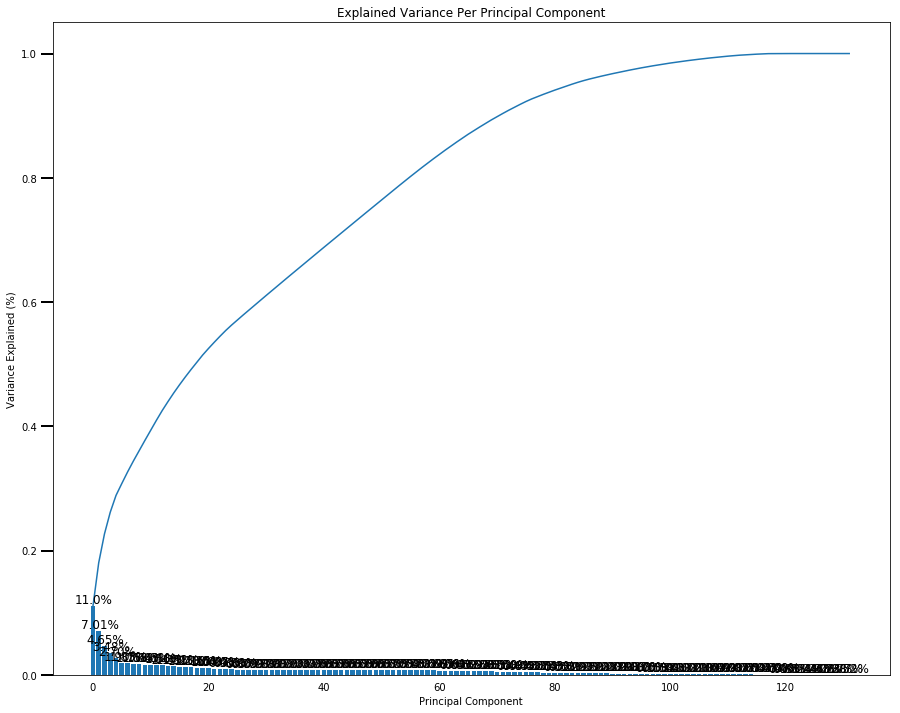

In [61]:
# With no component specified
scree_plot(pca)

135 components in the data. As seen above, at around 70, therecurve starts to flatten

In [62]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca, X_pca = do_pca(70, azdias_scaled)
comp_check = pca_results(azdias_scaled, pca)
    #if comp_check['Explained Variance'].sum() > 0.75:
     #   break

num_comps = comp_check.shape[0]

In [63]:
print(f"{comp_check['Explained Variance'].sum()} is the Explained variance")
print(f'{num_comps} is the number of components')

0.8923 is the Explained variance
70 is the number of components


In [64]:
comp_check.head()

,Explained Variance,0,1,2,3,4,5,6,7,8,...,122,123,124,125,126,127,128,129,130,131
Dimension 1,0.1101,-0.0712,0.0127,0.0286,-0.1832,0.1001,-0.0739,0.0400,0.0392,0.1511,...,0.0284,0.0376,0.0590,0.0601,0.0597,0.0188,0.0614,0.1081,-0.1929,-0.1128
Dimension 2,0.0701,0.2615,0.0335,-0.1329,0.1125,-0.2583,0.2457,-0.2284,-0.2340,0.0817,...,0.0389,-0.0067,0.0022,0.0061,0.0119,0.0421,-0.2615,-0.1863,-0.0468,0.0226
Dimension 3,0.0466,0.0164,-0.3570,-0.0347,0.1278,-0.0618,0.0434,-0.1530,-0.0804,-0.0605,...,0.0051,0.0042,0.0208,0.0294,0.0150,-0.0046,-0.0391,-0.0543,-0.0216,-0.0187
Dimension 4,0.0349,-0.0099,0.0258,0.0639,0.0270,0.0005,-0.0031,-0.0359,0.0077,-0.0369,...,-0.0045,0.0219,0.0118,0.0155,0.0076,-0.0032,0.0175,-0.0950,-0.0032,-0.0118
Dimension 5,0.0271,0.0703,-0.0065,-0.0395,-0.0310,-0.0207,0.0294,0.0722,-0.1139,0.0632,...,0.0470,0.0670,0.0424,0.0120,0.0316,0.0051,-0.0169,0.1582,-0.1822,-0.0931


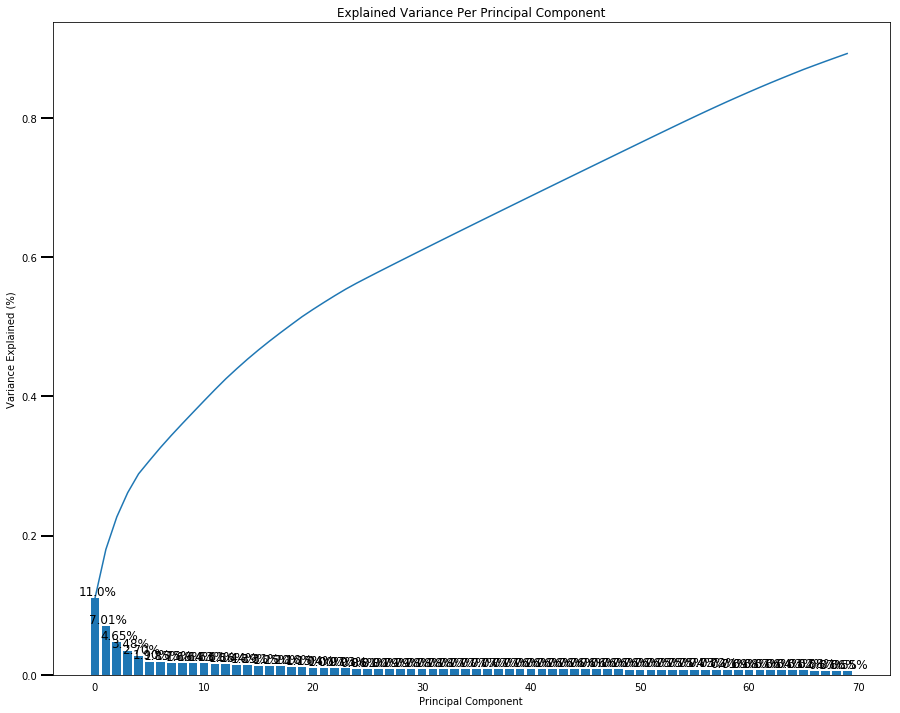

In [65]:
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

The first spree plot showing the total 135 components in the data  showed that when number of principle components is around 70, the percentage of explanable variance starts to decline. 70 components explained about 89.2% of variance in the data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [66]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

azdias_scaled.columns=azdias_clean.columns
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,-0.750972,-1.045218,-1.026509,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,0.105346,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,3.116720e-15,-7.697906e-16,-3.216984e-16,6.346104e-16
1,-1.742724,0.956738,0.859488,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,-1.403804,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,1.218829e+00,1.440957e+00,-1.258937e+00,-1.338297e+00
2,0.240781,0.956738,-0.397844,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,-1.403804,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,1.218829e+00,-1.375841e+00,9.142640e-01,8.052265e-01
3,1.232533,0.956738,-1.026509,0.700556,-0.560532,1.209329,-0.675554,-1.260597,-0.794475,1.111445,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-2.433020e-01,1.408961e-01,1.638664e+00,-6.237891e-01
4,0.240781,-1.045218,0.859488,0.700556,0.122179,0.452976,-1.329319,0.084637,-0.794475,0.608395,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-2.433020e-01,1.408961e-01,-5.345367e-01,9.071870e-02


In [67]:
azdias_clean.keys()

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP',
       ...
       'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A', 'CAMEO_DEU_2015_9B',
       'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E',
       'PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT',
       'CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFE_STAGE'],
      dtype='object', length=132)

In [68]:
components=pd.DataFrame(np.round(pca.components_, 4), columns = azdias_clean.keys())

In [69]:
components.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,-0.0712,0.0127,0.0286,-0.1832,0.1001,-0.0739,0.0400,0.0392,0.1511,-0.0442,...,0.0284,0.0376,0.0590,0.0601,0.0597,0.0188,0.0614,0.1081,-0.1929,-0.1128
1,0.2615,0.0335,-0.1329,0.1125,-0.2583,0.2457,-0.2284,-0.2340,0.0817,0.1202,...,0.0389,-0.0067,0.0022,0.0061,0.0119,0.0421,-0.2615,-0.1863,-0.0468,0.0226
2,0.0164,-0.3570,-0.0347,0.1278,-0.0618,0.0434,-0.1530,-0.0804,-0.0605,0.0867,...,0.0051,0.0042,0.0208,0.0294,0.0150,-0.0046,-0.0391,-0.0543,-0.0216,-0.0187
3,-0.0099,0.0258,0.0639,0.0270,0.0005,-0.0031,-0.0359,0.0077,-0.0369,0.0243,...,-0.0045,0.0219,0.0118,0.0155,0.0076,-0.0032,0.0175,-0.0950,-0.0032,-0.0118
4,0.0703,-0.0065,-0.0395,-0.0310,-0.0207,0.0294,0.0722,-0.1139,0.0632,0.0436,...,0.0470,0.0670,0.0424,0.0120,0.0316,0.0051,-0.0169,0.1582,-0.1822,-0.0931


A function for only first 20 components

In [70]:
components = pd.DataFrame(np.round(pca.components_, 4), columns = azdias_scaled.keys())
components.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,-0.0712,0.0127,0.0286,-0.1832,0.1001,-0.0739,0.0400,0.0392,0.1511,-0.0442,...,0.0284,0.0376,0.0590,0.0601,0.0597,0.0188,0.0614,0.1081,-0.1929,-0.1128
1,0.2615,0.0335,-0.1329,0.1125,-0.2583,0.2457,-0.2284,-0.2340,0.0817,0.1202,...,0.0389,-0.0067,0.0022,0.0061,0.0119,0.0421,-0.2615,-0.1863,-0.0468,0.0226
2,0.0164,-0.3570,-0.0347,0.1278,-0.0618,0.0434,-0.1530,-0.0804,-0.0605,0.0867,...,0.0051,0.0042,0.0208,0.0294,0.0150,-0.0046,-0.0391,-0.0543,-0.0216,-0.0187
3,-0.0099,0.0258,0.0639,0.0270,0.0005,-0.0031,-0.0359,0.0077,-0.0369,0.0243,...,-0.0045,0.0219,0.0118,0.0155,0.0076,-0.0032,0.0175,-0.0950,-0.0032,-0.0118
4,0.0703,-0.0065,-0.0395,-0.0310,-0.0207,0.0294,0.0722,-0.1139,0.0632,0.0436,...,0.0470,0.0670,0.0424,0.0120,0.0316,0.0051,-0.0169,0.1582,-0.1822,-0.0931


In [71]:
components = pd.DataFrame(np.round(pca.components_, 4), columns = azdias_scaled.keys()).iloc[2,:20]
components

ALTERSKATEGORIE_GROB     0.0164
ANREDE_KZ               -0.3570
CJT_GESAMTTYP           -0.0347
FINANZ_MINIMALIST        0.1278
FINANZ_SPARER           -0.0618
FINANZ_VORSORGER         0.0434
FINANZ_ANLEGER          -0.1530
FINANZ_UNAUFFAELLIGER   -0.0804
FINANZ_HAUSBAUER        -0.0605
FINANZTYP                0.0867
GFK_URLAUBERTYP          0.0020
GREEN_AVANTGARDE         0.0577
HEALTH_TYP              -0.0080
LP_LEBENSPHASE_FEIN      0.0037
LP_LEBENSPHASE_GROB      0.0028
LP_FAMILIE_FEIN         -0.0041
LP_FAMILIE_GROB         -0.0055
LP_STATUS_FEIN           0.0258
LP_STATUS_GROB           0.0420
NATIONALITAET_KZ        -0.0060
Name: 2, dtype: float64

In [72]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_results(full_dataset, pca,comp,feature_size=len(azdias_clean)):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    comp= what component to be displayed
    feature_size: how many futures to be showed, with 132 features as maximum and default.
    '''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = azdias_clean.keys()).iloc[comp,:feature_size]
    components=components.sort_values(ascending=False)
    #components.index = dimensions
   
    #''' 
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    #variance_ratios.index = dimensions
    #'''
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))
    
    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar',title='Principle Components');
    ax.set_ylabel("Feature Weights")
    #plt.show()
    
    #ax.set_xticklabels(dimensions, rotation=0)
    
    #''' 
    # Display the explained variance ratios
    #for i, ev in enumerate(pca.explained_variance_ratio_):
    #ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))
    #'''
    # Return a concatenated DataFrame
    data=pd.DataFrame(variance_ratios.iloc[comp].append(components)).transpose()
    data.rename(index={comp:dimensions[comp]},inplace=True)
    return data#pd.concat([variance_ratios.iloc[comp], components], axis = 1)

,Explained Variance,FINANZ_HAUSBAUER,FINANZ_SPARER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,CJT_GESAMTTYP,ANREDE_KZ,FINANZTYP,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,FINANZ_MINIMALIST
Dimension 1,0.1101,0.1511,0.1001,0.04,0.0392,0.0286,0.0127,-0.0442,-0.0712,-0.0739,-0.1832


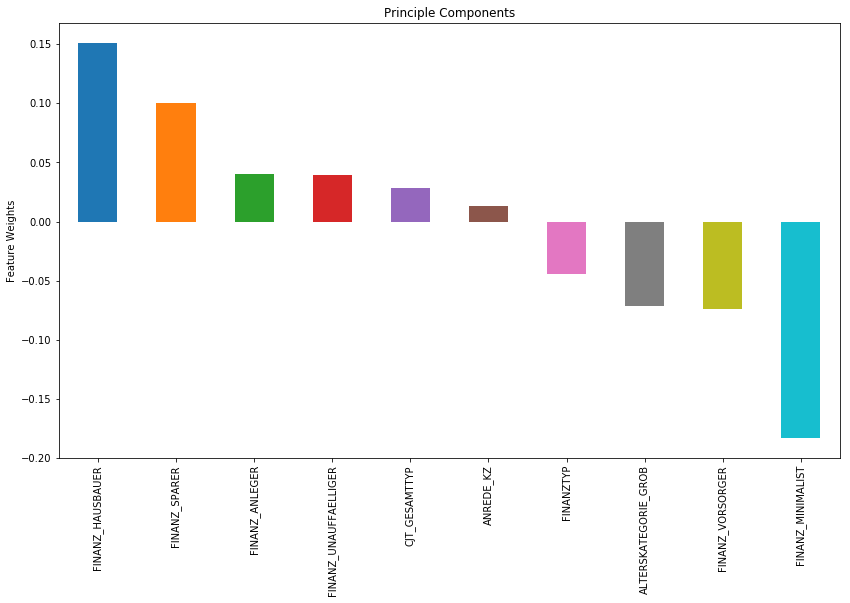

In [73]:
#First component, displaying only 10 features
comp_check = pca_results(azdias_scaled, pca,0,10)
comp_check

,Explained Variance,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,HH_EINKOMMEN_SCORE,ORTSGR_KLS9,EWDICHTE,FINANZ_HAUSBAUER,PLZ8_ANTG2,KBA05_ANTG4,...,KONSUMNAEHE,PLZ8_GBZ,FINANZ_MINIMALIST,KBA05_GBZ,CAMEO_INTL_2015_WEALTH,PLZ8_ANTG1,KBA05_ANTG1,LP_STATUS_GROB,LP_STATUS_FEIN,MOBI_REGIO
Dimension 1,0.1101,0.1948,0.1889,0.1846,0.1669,0.1661,0.1643,0.1511,0.1332,0.1326,...,-0.1436,-0.1439,-0.1832,-0.1888,-0.1929,-0.1954,-0.1981,-0.2018,-0.2044,-0.2121


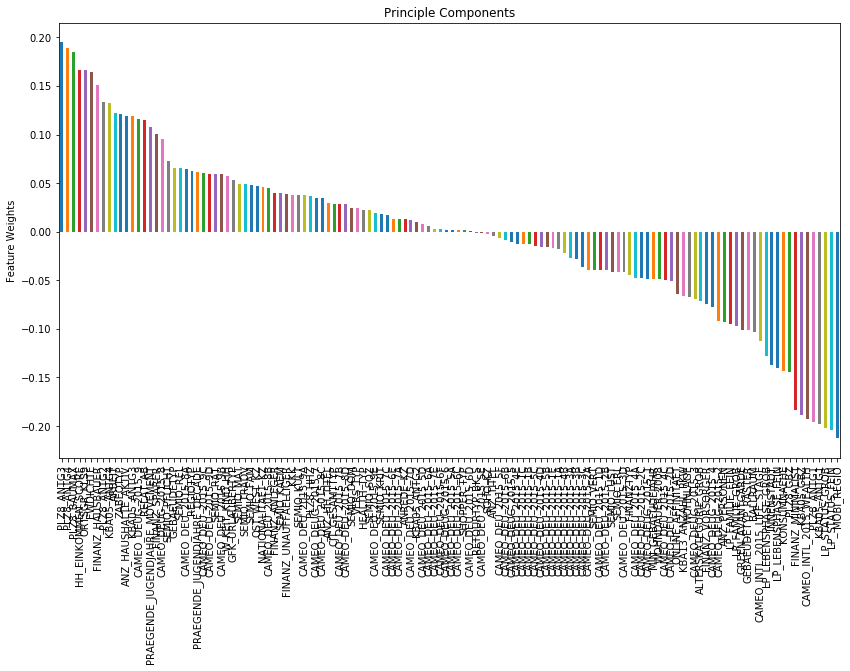

In [74]:
#First component, displaying all features
comp_check = pca_results(azdias_scaled, pca,0)
comp_check

,Explained Variance,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,FINANZTYP,FINANZ_MINIMALIST,FINANZ_HAUSBAUER,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_SPARER
Dimension 2,0.0701,0.2615,0.2457,0.1202,0.1125,0.0817,0.0335,-0.1329,-0.2284,-0.234,-0.2583


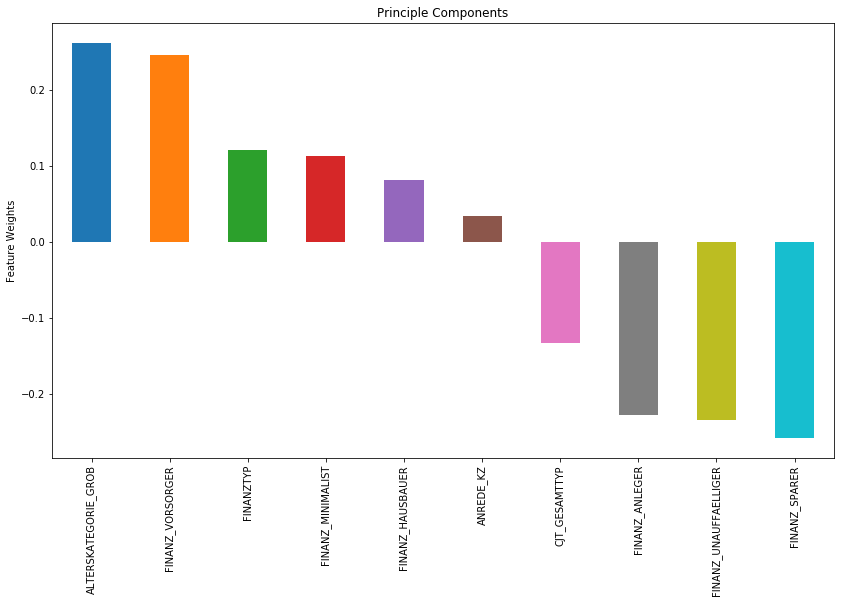

In [75]:
#second component, displaying only 10 features
comp_check = pca_results(azdias_scaled, pca,1,10)
comp_check

,Explained Variance,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,SEMIO_ERL,SEMIO_LUST,RETOURTYP_BK_S,W_KEIT_KIND_HH,FINANZTYP,FINANZ_MINIMALIST,SHOPPER_TYP,...,SEMIO_KULT,PRAEGENDE_JUGENDJAHRE_MOVEMENT,SEMIO_RAT,SEMIO_TRADV,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,SEMIO_PFLICHT,SEMIO_REL,FINANZ_SPARER,PRAEGENDE_JUGENDJAHRE_DECADE
Dimension 2,0.0701,0.2615,0.2457,0.2047,0.179,0.1675,0.1281,0.1202,0.1125,0.0841,...,-0.1679,-0.1863,-0.1957,-0.2234,-0.2284,-0.234,-0.2378,-0.2395,-0.2583,-0.2615


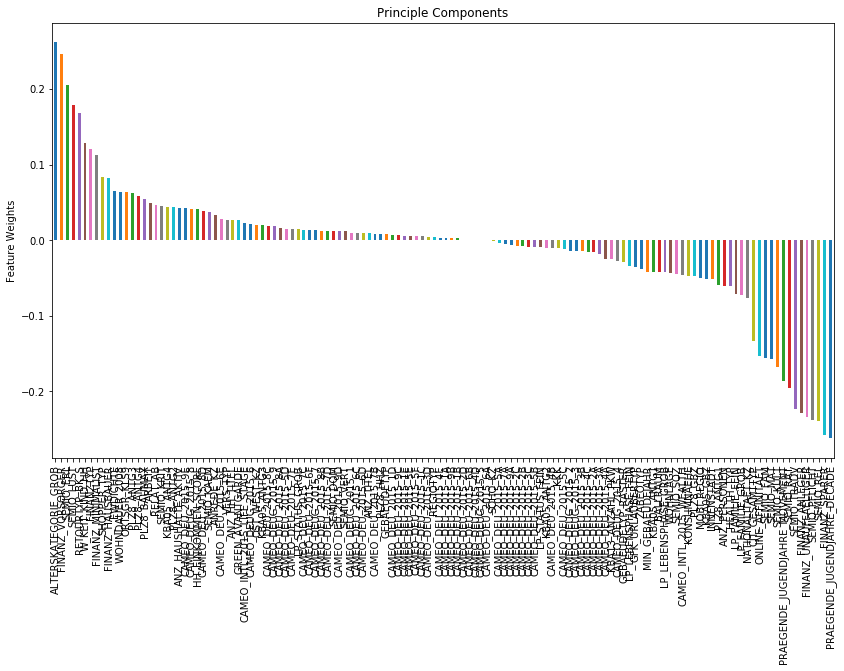

In [76]:
#second component, displaying only all features
comp_check = pca_results(azdias_scaled, pca,1)
comp_check

,Explained Variance,FINANZ_MINIMALIST,FINANZTYP,FINANZ_VORSORGER,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,FINANZ_HAUSBAUER,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_ANLEGER,ANREDE_KZ
Dimension 3,0.0466,0.1278,0.0867,0.0434,0.0164,-0.0347,-0.0605,-0.0618,-0.0804,-0.153,-0.357


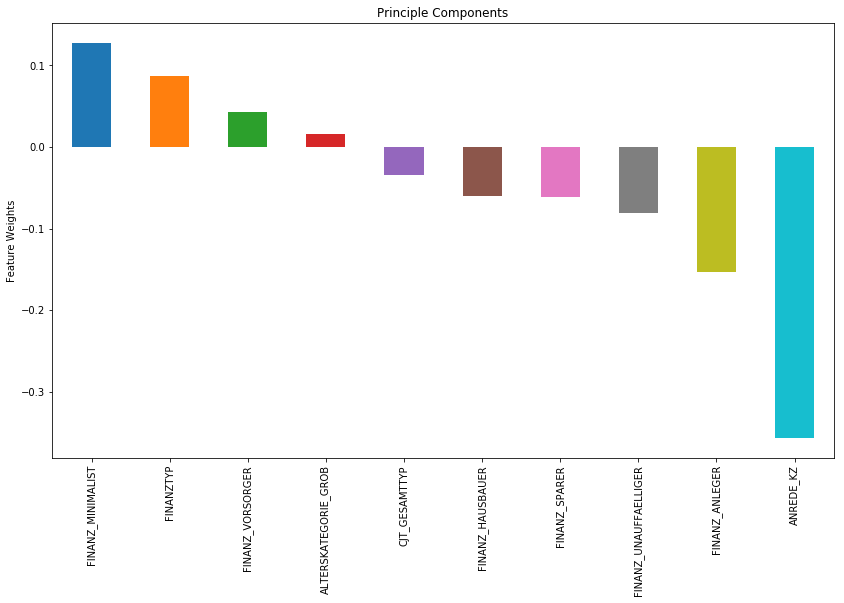

In [77]:
#third component, displaying only 10 features
comp_check = pca_results(azdias_scaled, pca,2,10)
comp_check

,Explained Variance,SEMIO_VERT,SEMIO_KULT,SEMIO_SOZ,SEMIO_FAM,FINANZ_MINIMALIST,FINANZTYP,SEMIO_REL,SEMIO_MAT,RETOURTYP_BK_S,...,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,SHOPPER_TYP,FINANZ_ANLEGER,SEMIO_RAT,SEMIO_ERL,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,ANREDE_KZ
Dimension 3,0.0466,0.3416,0.2906,0.2864,0.2467,0.1278,0.0867,0.081,0.0808,0.0666,...,-0.0618,-0.0804,-0.1508,-0.153,-0.1599,-0.198,-0.3027,-0.3248,-0.3542,-0.357


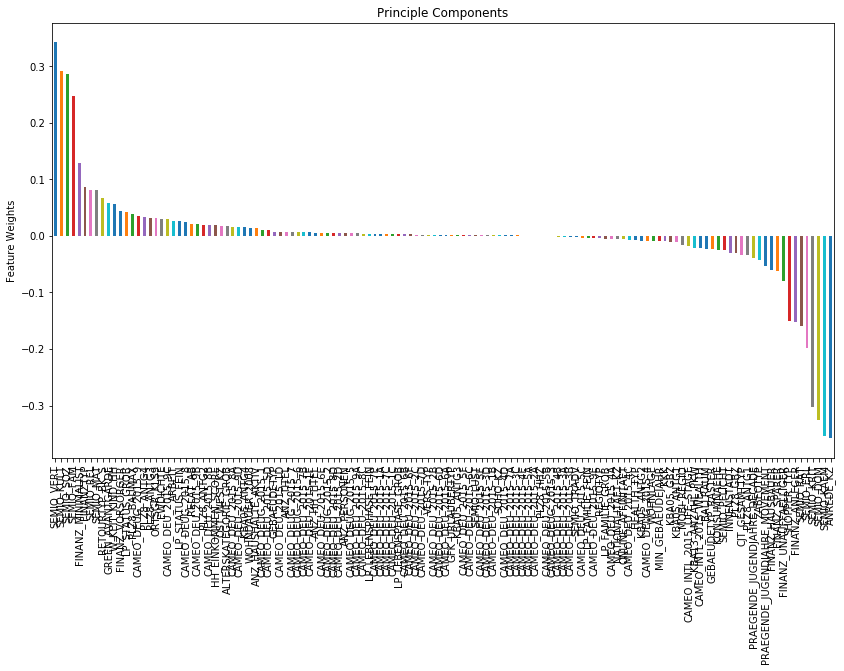

In [78]:
#Third component, displaying only all features
comp_check = pca_results(azdias_scaled, pca,2)
comp_check

### Discussion 2.3: Interpret Principal Components


The amount of variability captured by 1st,2nd and 3rd components are 11.0%,7.01% and 4.65% respectively. These variance explanations is called eigenvalue. Since each principle components identify a particular thing from the data, there weights varies between positive and negative. e.g 
In the first principal component, ALTERSKATEGORIE_GROB is -0.0712, while in the second principal component ALTERSKATEGORIE_GROB is 0.2615, thus this component observations by ALTERSKATEGORIE_GROB are distinct part of the feature but cummulatively identifies this feature better.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [79]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

In [80]:
def plot_data(data, labels):
    '''
    Plot data with colors associated with labels
    '''
    fig = plt.figure();
    ax = Axes3D(fig)
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='tab10');

In [81]:
pca, X_pca = do_pca(70, azdias_scaled)

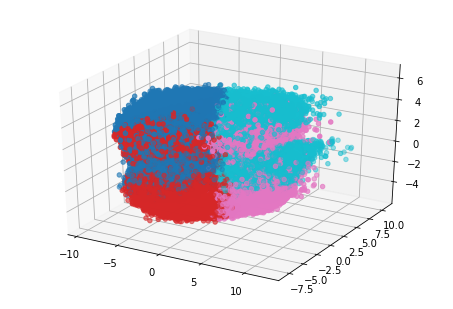

In [82]:
# Try instantiating a model with 4 centers
k_value=4
kmeans_4 =KMeans(k_value) #instantiate your model

# Then fit the model to your data using the fit method
model_4 = kmeans_4.fit(X_pca)#fit the model to your data using kmeans_4

# Finally predict the labels on the same data to show the category that point belongs to
labels =model_4.predict(X_pca) #predict labels using model_4 on your dataset

# If you did all of that correctly, this should provide a plot of your data colored by center
plot_data(X_pca, labels)

In [83]:
# A place for your work - create a scree plot - you will need to
# Fit a kmeans model with changing k from 1-10
# Obtain the score for each model (take the absolute value)
# Plot the score against k

def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)
    
    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [84]:
from sklearn.cluster import MiniBatchKMeans


def get_mini_batch_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    #kmeans = KMeans(n_clusters=center)
    kmeans=MiniBatchKMeans(n_clusters=center,random_state=0,batch_size=512)
    
    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

#kmeans = MiniBatchKMeans(n_clusters=2,random_state=0,batch_size=500)

scores = []
centers = list(range(1,40))

# Over a number of different cluster counts...
for center in centers:
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.
    scores.append(get_mini_batch_kmeans_score(X_pca, center))

In [85]:
'''
scores = []
centers = list(range(1,20))

# Over a number of different cluster counts...
for center in centers:
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.
    scores.append(get_kmeans_score(X_pca, center))
'''   


'\nscores = []\ncenters = list(range(1,20))\n\n# Over a number of different cluster counts...\nfor center in centers:\n    # run k-means clustering on the data and...\n    # compute the average within-cluster distances.\n    scores.append(get_kmeans_score(X_pca, center))\n'

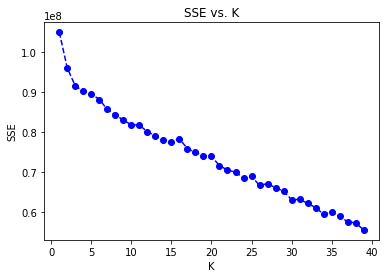

In [86]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
#stop here
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [87]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

center=17
kmeans = KMeans(n_clusters=center)
    
# Then fit the model to your data using the fit method
model = kmeans.fit(X_pca)
label=model.predict(X_pca)
model.inertia_ #17 it is 74108073.42154628

74158760.605462983

In [88]:
pop_preds=label
np.unique(pop_preds)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

I used Minibatchkmeans to to iterate over number of clusters that reduced SSE best.
Size of the mini batches. For faster computations, you can set the batch_size greater than 256 * number of cores to enable parallelism on all cores [source](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html)

My am using Intel core i3 6006u processor, meaning I have [2 cores](https://www.intel.com/content/www/us/en/products/sku/91157/intel-core-i36006u-processor-3m-cache-2-00-ghz/specifications.html).

so I can set batch sizer 256 *2=512, I can set batch size >=512, I simply used 512.

Size of cluster i choose is 17 because, after running 40 iterations, 17 seemed to be a good choice as the reduction in SSE leveled from 15, 16 and 17 number of clusters. Though increasing the number of clusters above 20 is likely to reduce SSE further as seen in the graph above.



### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [89]:
#uploaded_customers = files.upload()

customers=pd.read_csv("Udacity_CUSTOMERS_Subset.csv",sep=";")
#pd.read_csv(io.BytesIO(uploaded_customers["Udacity_CUSTOMERS_Subset.csv"]),sep=";")

# Load in the customer demographics data.
#customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv",sep=";")
customers.shape

(191652, 85)

In [90]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean=clean_data(customers)


In [91]:
customers_clean.shape

(191652, 139)

In [92]:
customers_clean.isnull().sum().sum()

2532804

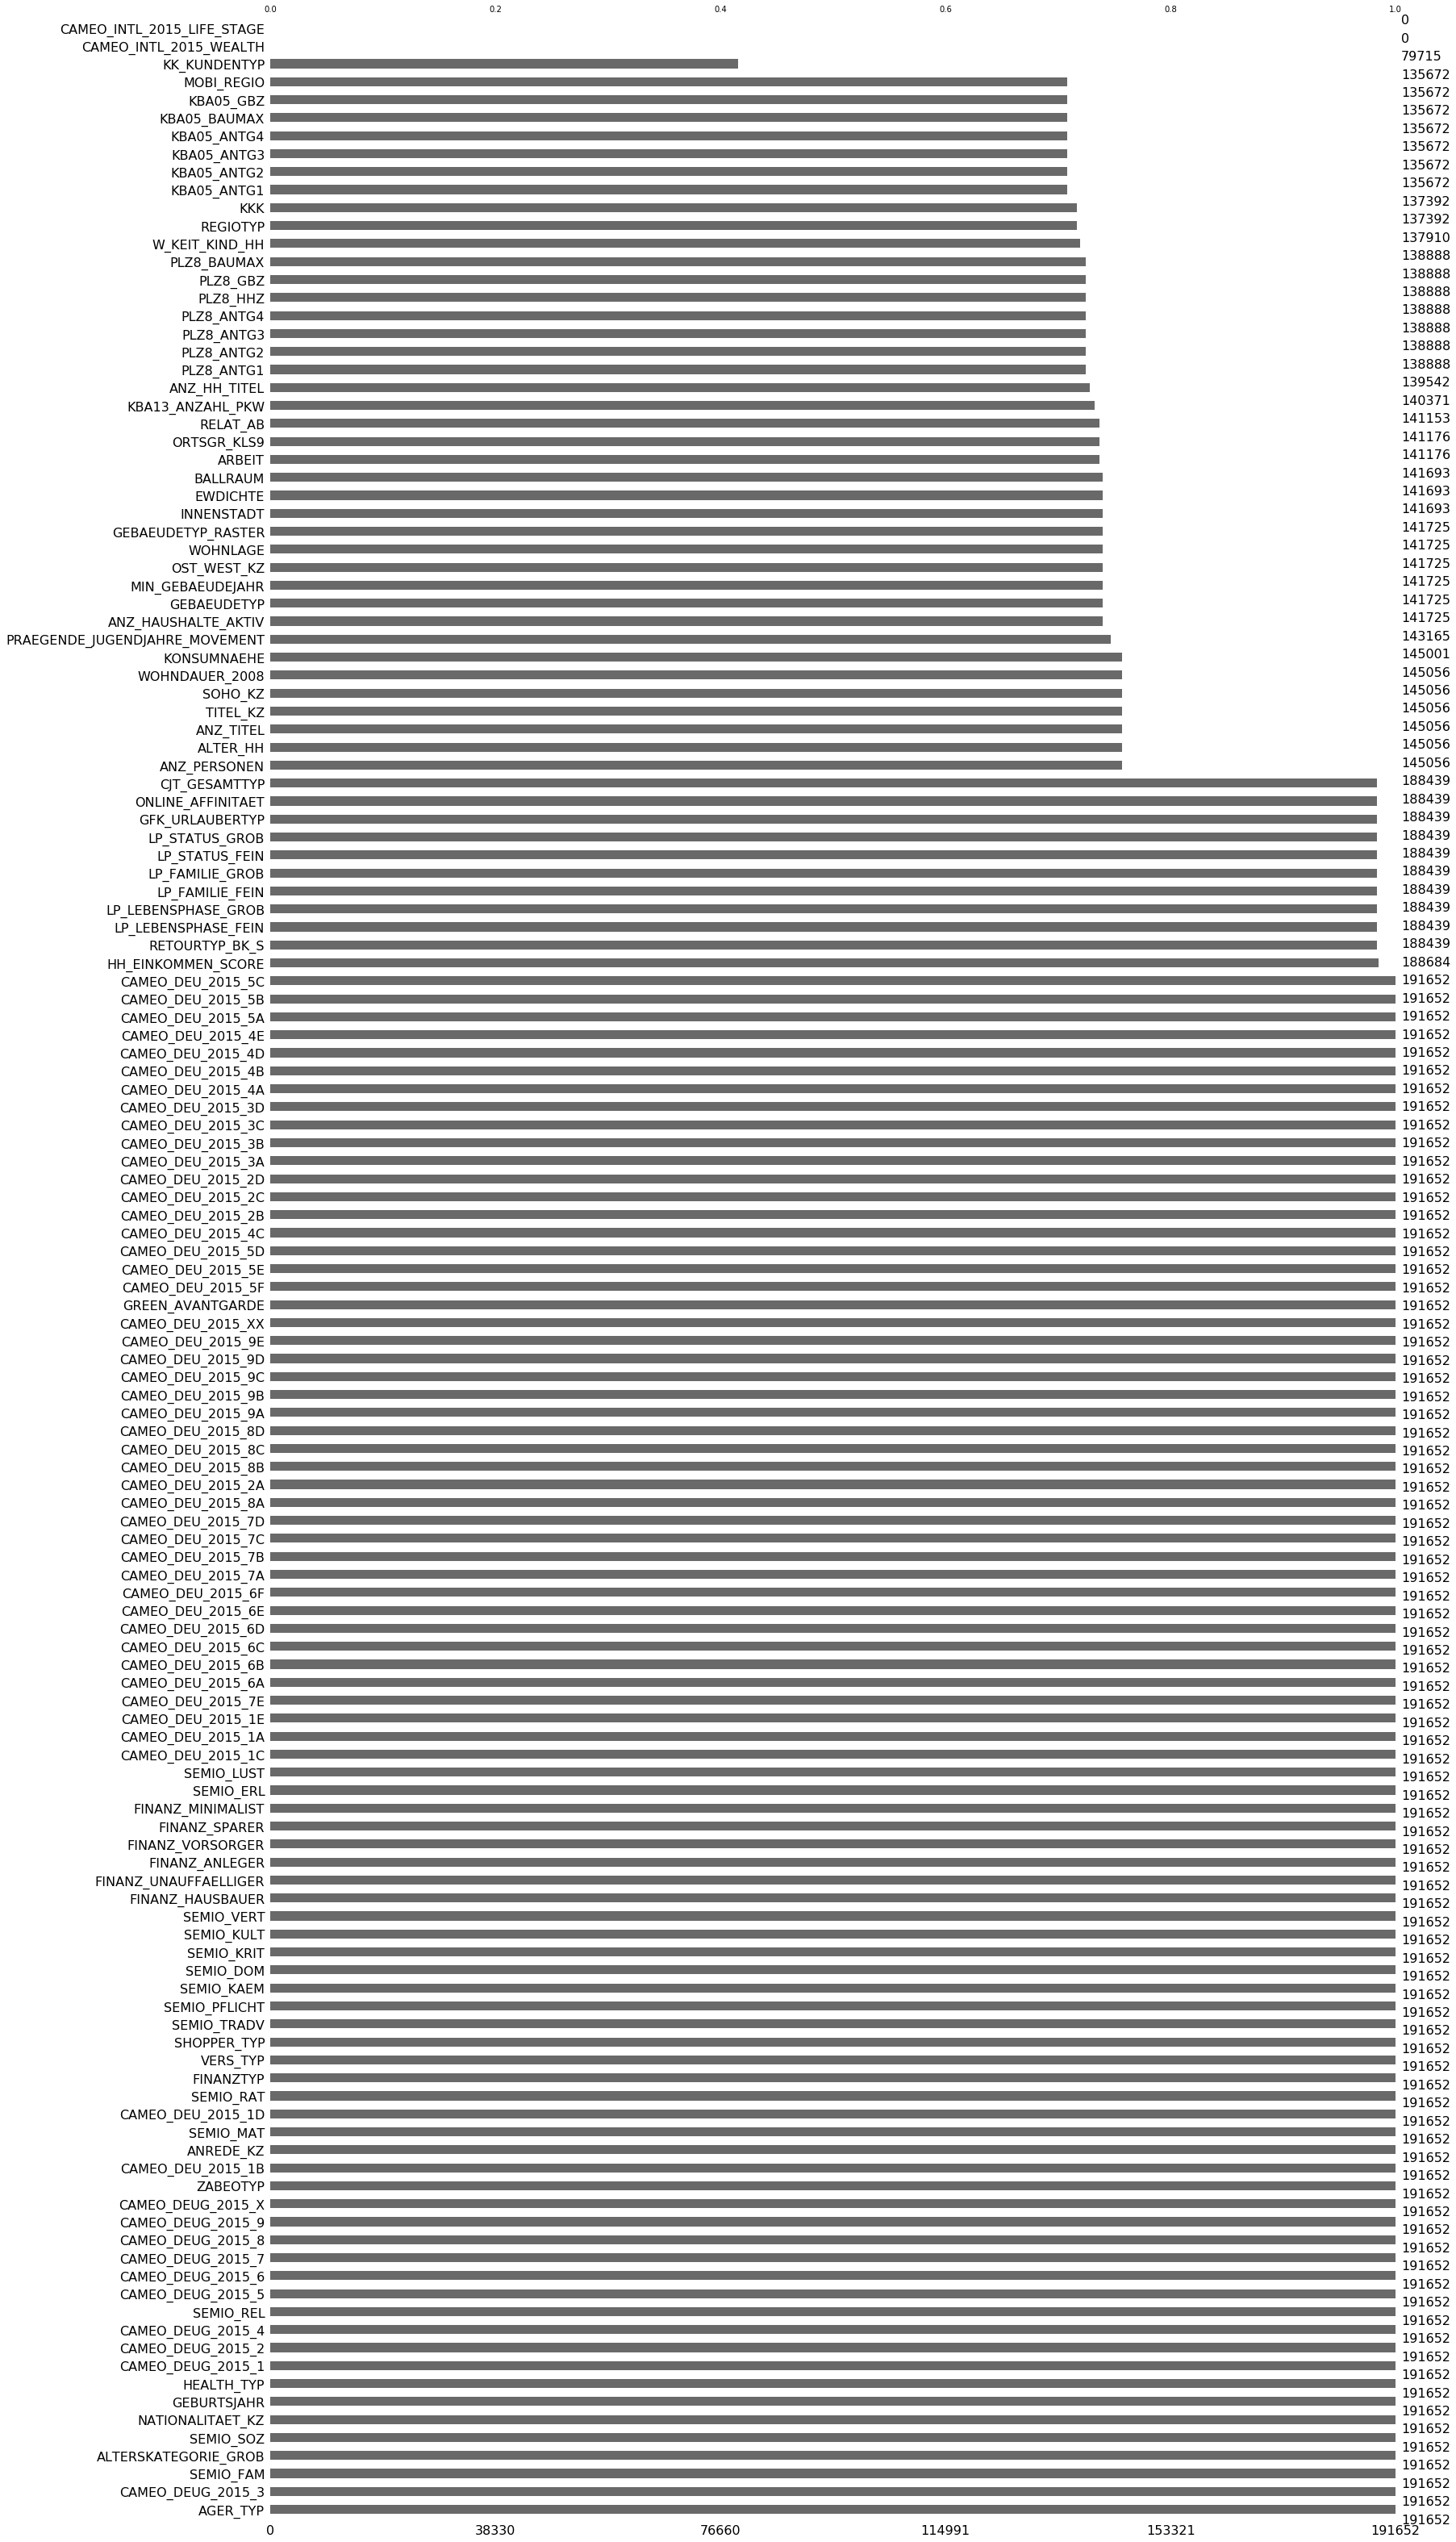

In [93]:
msno.bar(customers_clean,sort="descending")

In [94]:
#customers_clean[customers_clean.isnull().sum(axis=1)>=190000].count()
completly_null=customers_clean.isnull().sum()[customers_clean.isnull().sum()==customers_clean.shape[0]].sort_values(ascending=False)
completly_null=pd.DataFrame(completly_null).transpose()
outlier_cols=completly_null.columns.tolist()
customers_clean=customers_clean.drop(list(outlier_cols),axis=1)

In [95]:
customers_clean.shape

(191652, 137)

In [96]:
#from sklearn.preprocessing import Imputer

customers_clean_mean=customers_clean
imputer = Imputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(customers_clean_mean)
customers_clean_mean= imputer.transform(customers_clean_mean)

customers_clean_mean.shape


(191652, 137)

In [97]:
scaler=StandardScaler()
customers_scaled = scaler.fit_transform(customers_clean_mean)
#X = StandardScaler().fit_transform(customers_scaled)
''' 
pca_cust = PCA()
X_pca_cust = pca.fit_transform(customers_scaled)

scree_plot(pca_cust)
'''

' \npca_cust = PCA()\nX_pca_cust = pca.fit_transform(customers_scaled)\n\nscree_plot(pca_cust)\n'

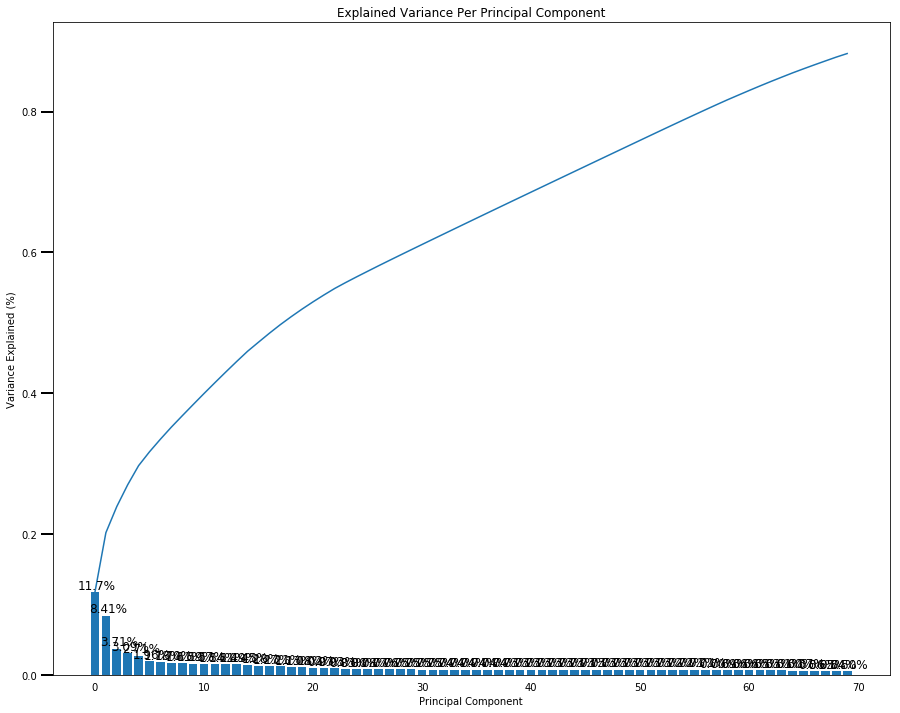

In [98]:
pca_cust, X_pca_cust = do_pca(70, customers_scaled)
scree_plot(pca_cust)

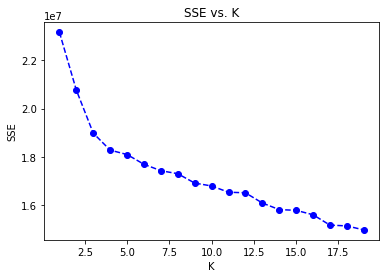

In [99]:
scores = []
centers = list(range(1,20))

# Over a number of different cluster counts...
for center in centers:
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.
    scores.append(get_mini_batch_kmeans_score(X_pca_cust, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [100]:
'''

scores = []
centers = list(range(1,20))

for center in centers:
    scores.append(get_kmeans_score(X_pca_cust, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');
'''

"\n\nscores = []\ncenters = list(range(1,20))\n\nfor center in centers:\n    scores.append(get_kmeans_score(X_pca_cust, center))\n    \nplt.plot(centers, scores, linestyle='--', marker='o', color='b');\nplt.xlabel('K');\nplt.ylabel('SSE');\nplt.title('SSE vs. K');\n"

In [122]:
#instantiate kmeans
center= 17
kmeans = KMeans(n_clusters=center)
cust_preds = model.fit_predict(X_pca_cust)

In [123]:
np.unique(cust_preds)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16], dtype=int32)

In [124]:
# checking cluster quality lower is better
#at 17, inertia is 14784428.870326286
model.inertia_

14876906.115477102

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

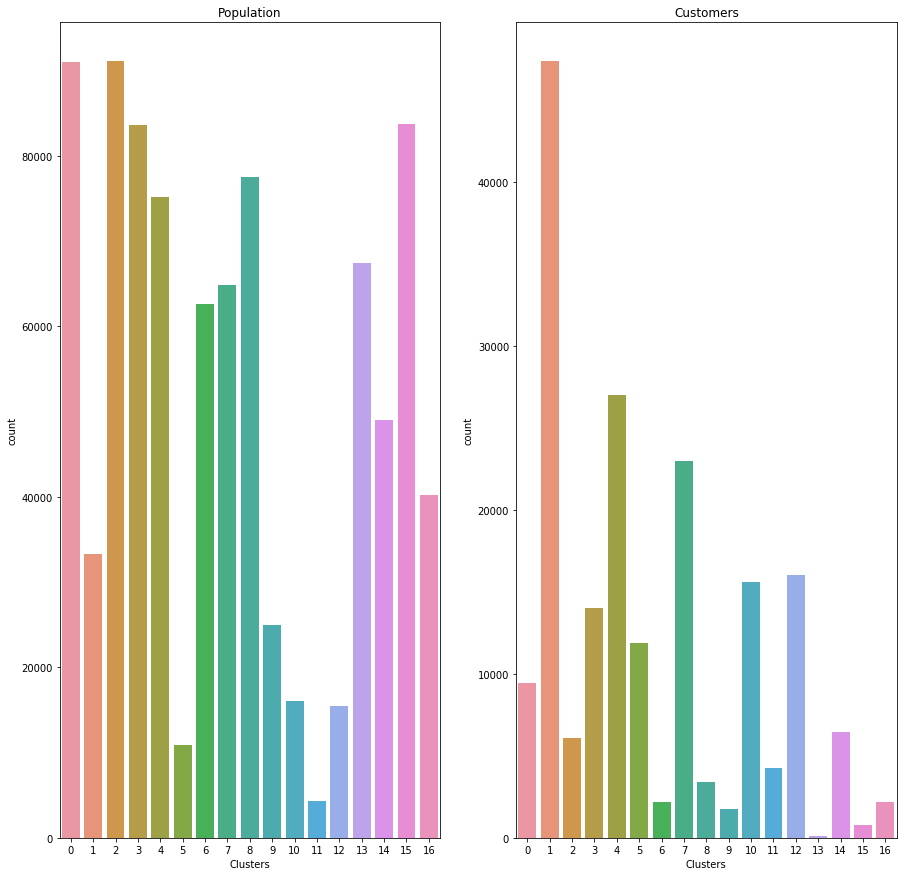

In [125]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
import seaborn as sns
#import pandas as pd
#import matplotlib.pyplot as plt



fig, ax =plt.subplots(1,2)
fig.set_figheight(15)
fig.set_figwidth(15)
ax[0].set_title('Population')
ax[1].set_title('Customers')
ax[0].set_xlabel('Clusters')
ax[1].set_xlabel('Clusters')
sns.countplot(pop_preds, ax=ax[0])
sns.countplot(cust_preds, ax=ax[1])
plt.show()


**Over Represented**:

- population cluster 0 is the most represented.
- customers, cluster 1 is the most represented.

**Under Represented**:

- population cluster 11 is the least represented.
- customers, cluster 13 is the least represented.

In [105]:
#model.cluster_centers_.shape

In [106]:
#customers_clean.head()
#X_pca_cust.shape

In [107]:
#customer_data=pd.DataFrame(X_pca_cust)
#customer_data['label']=cust_preds

#customer_data.head()

In [108]:
#len(cols)
#customers_clean.shape
#scaler.inverse_transform(pca_cust.inverse_transform(X_pca_cust)).shape
#customers_clean.head()

def data_transform(pca,X_pca,col_list,predictions,scaler):
  data=pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(X_pca)),columns=col_list)
  data['label']=predictions
  return data

Customer Data

In [109]:
#customer_data=pd.DataFrame(scaler.inverse_transform(pca_cust.inverse_transform(X_pca_cust)),columns=customers_clean.columns)
#customer_data['label']=cust_preds
#customer_data.head()
#customers_clean_mean.shape

In [141]:
customer_data=data_transform(pca_cust,X_pca_cust,customers_clean.columns,cust_preds,scaler)
customer_data.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,PRAEGENDE_JUGENDJAHRE_MOVEMENT,label
0,1.081436,4.526411,0.854694,2.667850,5.183001,1.002446,4.943840,0.974294,2.243350,2.263293,...,0.003350,-0.017441,0.001717,-0.012700,0.000541,-0.015097,0.003127,-0.000056,48.674577,3
1,0.041414,3.945709,0.885278,3.373857,4.301952,2.003484,4.199542,2.128709,3.167519,2.173292,...,0.013740,-0.000899,0.008800,0.003446,0.003349,-0.009852,-0.008114,0.001617,60.079411,4
2,0.317488,3.717428,1.961989,1.728232,4.290732,1.436621,4.527722,1.781974,2.625734,2.986330,...,-0.009781,0.010537,-0.010356,-0.001456,0.001781,0.013197,-0.010905,-0.000167,50.185612,12
3,0.982732,3.345751,0.909656,2.726284,5.088258,1.101212,5.061620,1.726088,1.228186,2.194891,...,-0.006631,0.009699,0.001878,0.005452,-0.002655,0.009839,-0.003898,0.000503,49.498320,5
4,-0.010887,2.703154,1.130761,4.535663,3.039585,2.663968,3.581895,2.592947,3.280591,3.275659,...,0.001550,0.010623,-0.004179,-0.003210,-0.007479,-0.008057,0.008303,0.000018,78.012038,8


In [137]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?


# subset the customer data where it is 1
customer_data[customer_data['label']==1].describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,PRAEGENDE_JUGENDJAHRE_MOVEMENT,label
count,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,...,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.0
mean,0.783260,3.452497,1.962454,2.994909,4.190374,1.500641,4.484292,2.070700,2.072043,2.637530,...,0.019191,0.005194,0.005314,0.000194,0.000530,0.002234,0.000681,0.000104,60.733357,1.0
std,1.247461,0.661043,0.122275,0.988807,0.542711,0.780091,0.768854,0.859973,0.780063,0.885060,...,0.130631,0.067988,0.064629,0.007374,0.023405,0.034217,0.022996,0.000536,12.773486,0.0
min,-3.338678,0.770890,1.161130,0.103838,1.250561,0.052751,1.643451,0.121070,0.200080,-0.276717,...,-0.040642,-0.065618,-0.039402,-0.031435,-0.031142,-0.075073,-0.172608,-0.001563,33.162045,1.0
25%,-0.298905,3.137365,1.887180,2.274510,3.901856,0.908619,3.922566,1.414587,1.567761,2.105456,...,-0.006889,-0.008299,-0.005839,-0.004528,-0.003367,-0.010785,-0.010031,-0.000237,51.187291,1.0
50%,1.254544,3.542835,1.970832,2.949998,4.328223,1.236329,4.744548,1.910264,1.986500,2.697280,...,0.000859,0.000890,0.001258,0.000089,0.000284,0.001135,-0.001674,0.000003,56.731896,1.0
75%,1.745006,3.937933,2.044488,3.699285,4.583121,2.095751,5.058412,2.634371,2.458281,3.166987,...,0.009960,0.010239,0.008286,0.004890,0.003797,0.012408,0.007423,0.000281,71.066503,1.0
max,4.047675,4.728482,2.365707,6.042753,5.285082,4.175432,5.713989,5.208065,5.328789,5.667178,...,1.014623,0.993581,0.997870,0.095643,0.984489,0.949398,0.469011,0.002102,99.301691,1.0


Population data

In [112]:
azdias_scaled.shape

(891221, 132)

In [142]:
population_data=data_transform(pca,X_pca,azdias_clean.columns,pop_preds,azdias_scaler)
population_data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE,label
0,2.351129,1.461440,2.964112,2.719287,4.067492,2.989424,4.855554,4.980653,3.202574,3.240272,...,0.014229,0.013327,-0.004596,-0.009106,-0.004531,70.613513,8.359090,2.783905,2.913339,3
1,1.234660,1.978990,4.669537,0.355647,5.051238,1.765986,4.814099,4.156666,4.287556,1.212208,...,-0.001175,0.002780,-0.004241,-0.017920,0.006367,94.806754,11.744730,1.077939,1.073304,2
2,2.865312,2.123551,3.246099,1.460607,3.797769,2.437771,3.296737,3.672826,3.678739,1.576944,...,0.013431,0.020350,0.010718,0.000949,-0.015503,84.185544,5.315790,3.991145,4.002074,0
3,3.516490,1.774647,1.904402,4.517058,1.129589,4.361694,2.110187,1.573625,1.804729,4.353259,...,0.011081,-0.003930,0.017208,-0.001528,-0.004497,67.841190,6.892377,4.988218,1.971024,7
4,3.294933,0.758720,4.741387,3.634519,2.424466,3.987112,1.615011,2.207733,2.301915,4.909076,...,0.011773,0.009828,0.018555,-0.023298,-0.010130,75.532599,9.152513,2.018540,3.004420,15


In [114]:
#population_data=pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(X_pca)),columns=azdias_clean.columns)
#population_data['label']=label
#population_data.head()

In [138]:
# subset the population data where it is 0
population_data[population_data['label']==0].describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE,label
count,91070.000000,91070.000000,91070.000000,91070.000000,91070.000000,91070.000000,91070.000000,91070.000000,91070.000000,91070.000000,...,91070.000000,91070.000000,91070.000000,91070.000000,91070.000000,91070.000000,91070.000000,91070.000000,91070.000000,91070.0
mean,2.897634,1.514144,3.446435,3.800512,2.450023,3.630732,2.930652,2.679910,2.279518,3.938934,...,-0.002268,-0.002834,-0.000488,0.001593,0.000029,72.779418,6.546743,3.990757,3.275078,0.0
std,0.906563,0.460391,1.332083,1.060432,1.260012,1.166073,1.248305,1.184347,1.088817,1.569307,...,0.015463,0.021042,0.014283,0.027971,0.011965,12.325471,4.525273,0.159886,0.985772,0.0
min,0.470574,0.510533,-0.472161,0.336813,-0.063152,0.512200,-0.440931,-0.258986,-1.065651,-1.156907,...,-0.076980,-0.090870,-0.072750,-0.118763,-0.051375,44.651590,-5.264406,2.672986,1.787429,0.0
25%,2.205618,1.072038,2.380919,3.118716,1.299946,2.536357,1.951597,1.800184,1.422792,2.927099,...,-0.012791,-0.016958,-0.009803,-0.017569,-0.008163,61.517340,3.256268,3.884311,2.029404,0.0
50%,2.977040,1.715298,3.506789,4.035229,2.240596,3.689852,2.801787,2.381610,2.211859,4.038734,...,-0.002484,-0.003263,-0.000110,0.001248,0.000129,72.784158,6.517367,3.989684,3.939394,0.0
75%,3.660678,1.946667,4.458601,4.633456,3.732193,4.707724,3.933529,3.793618,3.035516,5.152785,...,0.008174,0.011225,0.009295,0.020078,0.008212,83.829611,10.114557,4.095274,4.012189,0.0
max,4.952124,2.404259,8.434262,6.113684,5.303959,6.299658,6.566105,6.054816,5.854515,8.548818,...,0.060897,0.074773,0.053623,0.125335,0.047419,101.666000,17.124093,4.643609,5.195591,0.0


In [143]:
pop_overrep=population_data[population_data['label']==0]
cust_overrep=customer_data[customer_data['label']==1]

In [144]:
cust_overrep_len=np.round(len(customer_data[customer_data['label']==1])/len(customer_data)*100,2)
print(f"There are {cust_overrep_len}% of customers belonging to  cluster 1")

pop_cust_rep_len=np.round((len(population_data[population_data['label']==1])/len(population_data))*100,2)
print(f"And {pop_cust_rep_len}% of population belonging to  cluster 1")

#print("".format(len(customer_data[customer_data['label']==0])/len(customer_data)*100))

There are 24.72% of customers belonging to  cluster 1
And 3.73% of population belonging to  cluster 1


People in cluster 1 are target audience for the company

what type of people in cluster 1.

using some personal level columns to interprete the result.

**Using a cleaner data to compare**

In [118]:
#customers_clean_mean
def data_after_cleaning(array_data,col_list,predictions):
  data=pd.DataFrame(array_data,columns=col_list)
  data['label']=predictions
  return data

In [145]:
customer_clean_data=data_after_cleaning(customers_clean_mean,customers_clean.columns,cust_preds)
population_clean_data=data_after_cleaning(azdias_clean_mean,azdias_clean.columns,pop_preds)
pop_overrep=population_clean_data[population_clean_data['label']==0]
cust_overrep=customer_clean_data[customer_clean_data['label']==1]

In [146]:
cust_overrep_len=np.round(len(customer_clean_data[customer_clean_data['label']==1])/len(customer_clean_data)*100,2)
print(f"There are {cust_overrep_len}% of customers belonging to  cluster 1")

pop_cust_rep_len=np.round((len(population_clean_data[population_clean_data['label']==1])/len(population_clean_data))*100,2)
print(f"And {pop_cust_rep_len}% of population belonging to  cluster 1")

There are 24.72% of customers belonging to  cluster 1
And 3.73% of population belonging to  cluster 1


This yields same result with the previous.

In [147]:
#sns.countplot(x='ANREDE_KZ',data=pop_overrep)
#plt.show()
'''
from matplotlib import pyplot as plt
%matplotlib inline

for col in features:
    data.boxplot(column=col, by=label, figsize=(6,6))
    plt.title(col)
plt.show()
'''

'\nfrom matplotlib import pyplot as plt\n%matplotlib inline\n\nfor col in features:\n    data.boxplot(column=col, by=label, figsize=(6,6))\n    plt.title(col)\nplt.show()\n'

In [ ]:
'''

fig =plt.figure(figsize=(12,8))
axis1=fig.add_subplot(121)
axis1.title.set_text('over represented population cluster')
sns.countplot(x='ANREDE_KZ',data=pop_overrep)
#sns.displot(pop_overrep['ANREDE_KZ'], kind='kde')

axis2=fig.add_subplot(122)
axis2.title.set_text('over represented customer cluster')
sns.countplot(x='ANREDE_KZ',data=customer_data)
#sns.displot(customer_data['ANREDE_KZ'], kind='kde')
'''

compare both data Overepresented

In [ ]:
#sns.displot(population_clean_data['ANREDE_KZ'], kind='kde')
#sns.countplot(x='ANREDE_KZ',data=population_clean_data)
#plt.show()

In [159]:
def compare_datasets(col_name,population_data,customer_data):
    fig =plt.figure(figsize=(15,8))
    
    axis1=fig.add_subplot(121)
    axis1.title.set_text('population cluster')
    #sns.displot(population_data[col_name], kind='kde')
    sns.countplot(x=col_name,data=population_data)

    axis2=fig.add_subplot(122)
    axis2.title.set_text('customer cluster')
    #sns.displot(customer_data[col_name], kind='kde')
    sns.countplot(x=col_name,data=customer_data)

In [ ]:
#compare_datasets(first_five_col='ANREDE_KZ',pop_overrep,cust_overrep)

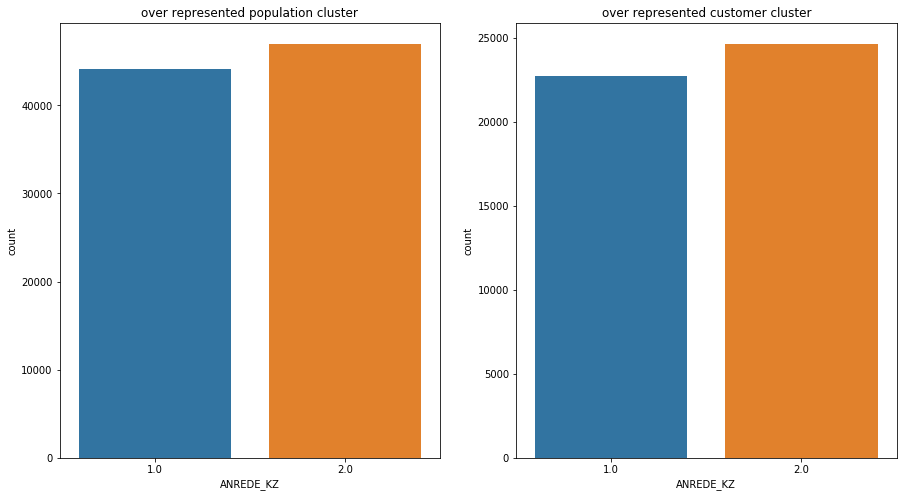

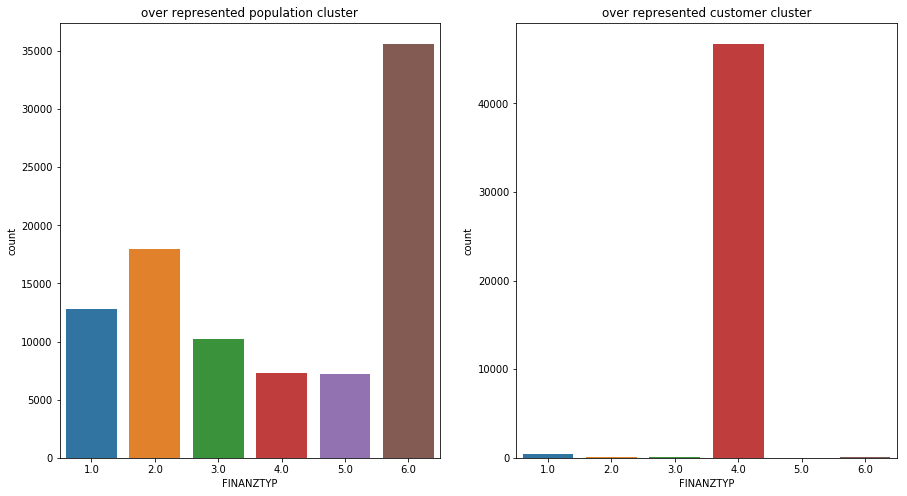

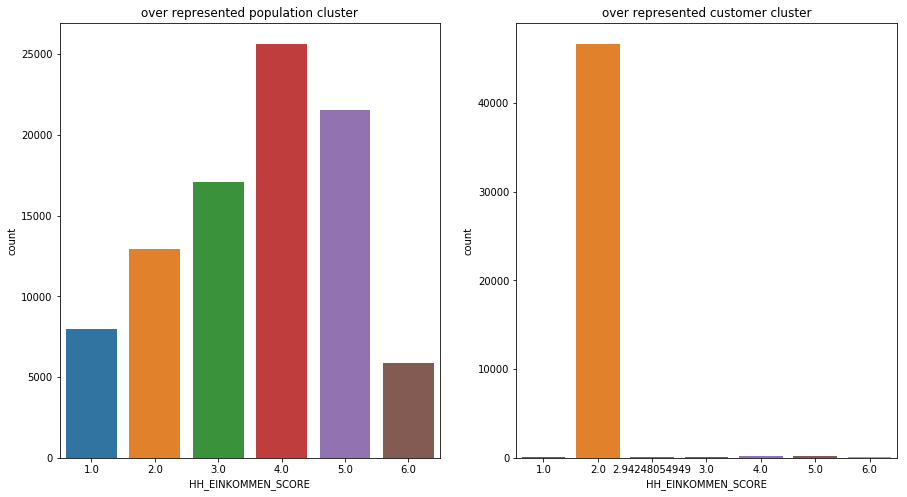

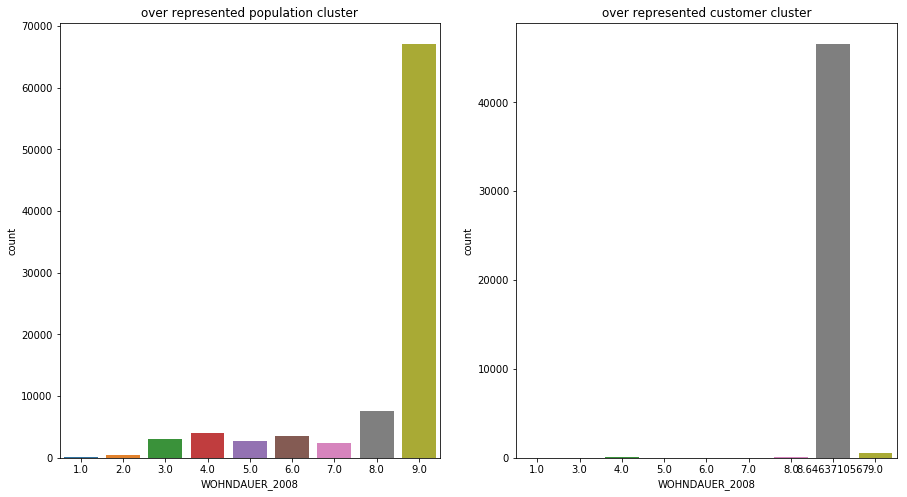

In [149]:

first_five_col=['ANREDE_KZ', 'FINANZTYP','HH_EINKOMMEN_SCORE','WOHNDAUER_2008']

for col in first_five_col:
    compare_datasets(col,pop_overrep,cust_overrep)


ANREDE_KZ:
-  1: male
-  2: female

FINANZTYP:
Most descriptive financial type for individual
-  1: low financial interest (MINIMALIST)
-  2: money-saver (SPARER)
-  3: home ownership (HAUSBAUER)
-  4: be prepared (VORSORGER)
-  5: investor (ANLEGER)
-  6: inconspicuous (UNAUFFAELLIGER)

HH_EINKOMMEN_SCORE
Estimated household net income

-  1: highest income
-  2: very high income
-  3: high income
-  4: average income
-  5: lower income
-  6: very low income

WOHNDAUER_2008:
Length of residence
-  1: length of residence less than 1 year
-  2: length of residence 1-2 years
-  3: length of residence 2-3 years
-  4: length of residence 3-4 years
-  5: length of residence 4-5 years
-  6: length of residence 5-6 years
-  7: length of residence 6-7 years
-  8: length of residence 7-10 years
-  9: length of residence more than 10 years

People part of the highest clusters are: 
Either male or female with financial type be prepared, with estimated very high household net income and people who have stayed at a residence between 8 to 9 years.

In [157]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
pop_underrep=population_clean_data[population_clean_data['label']==11]
cust_underrep=customer_clean_data[customer_clean_data['label']==13]

cust_underrep_len=np.round(len(customer_clean_data[customer_clean_data['label']==13])/len(customer_clean_data)*100,2)
print(f"There are {cust_underrep_len}% of customers belonging to  cluster 13")

pop_cust_rep_len=np.round((len(population_clean_data[population_clean_data['label']==13])/len(population_clean_data))*100,2)
print(f"And {pop_cust_rep_len}% of population belonging to  cluster 13")


'''
pop_underrep=population_data[population_data['label']==11]
cust_underrep=customer_data[customer_data['label']==13]

cust_underrep_len=np.round(len(customer_clean_data[customer_clean_data['label']==13])/len(customer_clean_data)*100,2)
print(f"There are {cust_underrep_len}% of customers belonging to  cluster 13")

pop_cust_rep_len=np.round((len(population_clean_data[population_clean_data['label']==13])/len(population_clean_data))*100,2)
print(f"And {pop_cust_rep_len}% of population belonging to  cluster 13")
'''

There are 0.07% of customers belonging to  cluster 13
And 7.57% of population belonging to  cluster 13


'\npop_underrep=population_data[population_data[\'label\']==11]\ncust_underrep=customer_data[customer_data[\'label\']==13]\n\ncust_underrep_len=np.round(len(customer_clean_data[customer_clean_data[\'label\']==13])/len(customer_clean_data)*100,2)\nprint(f"There are {cust_underrep_len}% of customers belonging to  cluster 13")\n\npop_cust_rep_len=np.round((len(population_clean_data[population_clean_data[\'label\']==13])/len(population_clean_data))*100,2)\nprint(f"And {pop_cust_rep_len}% of population belonging to  cluster 13")\n'

 The proportion of the data in a cluster 13 is larger in the general population than the customer data with only 0.07% of customers closest to a population centroid that captures 7.57% of the data, thus suggesting that group of persons in cluster 13 are outside of the target demographics.

In [154]:
#population_data

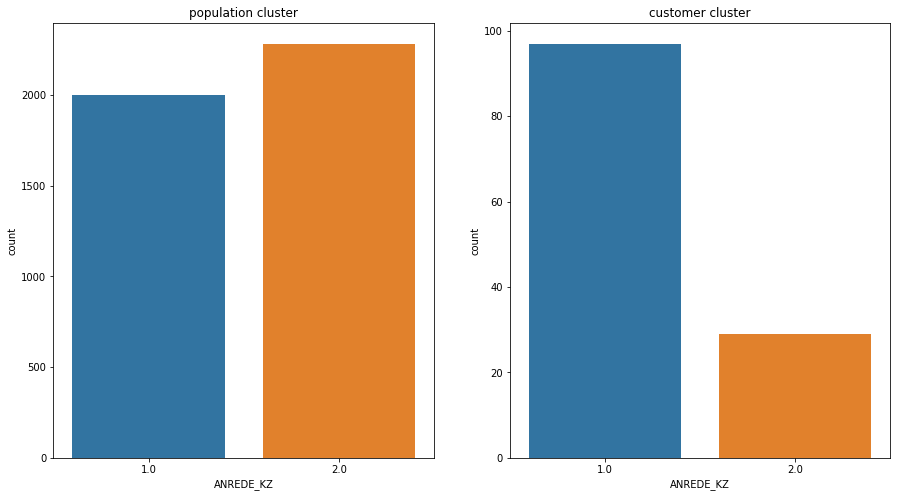

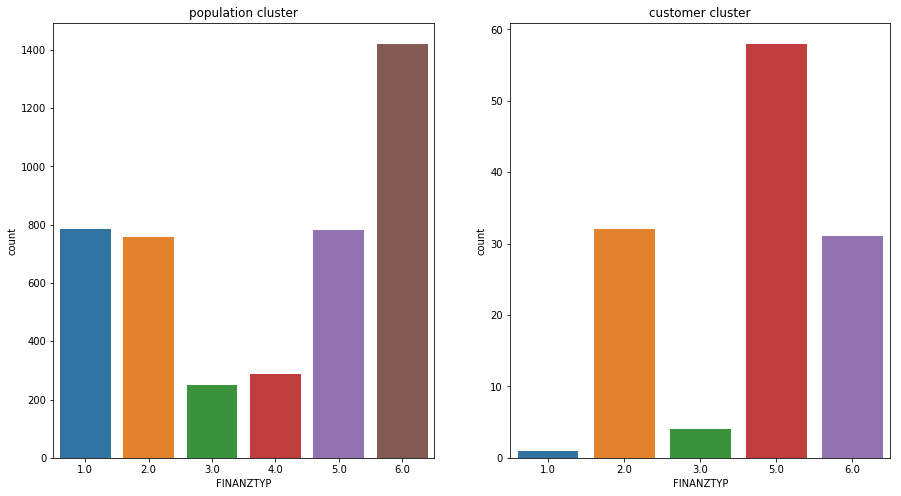

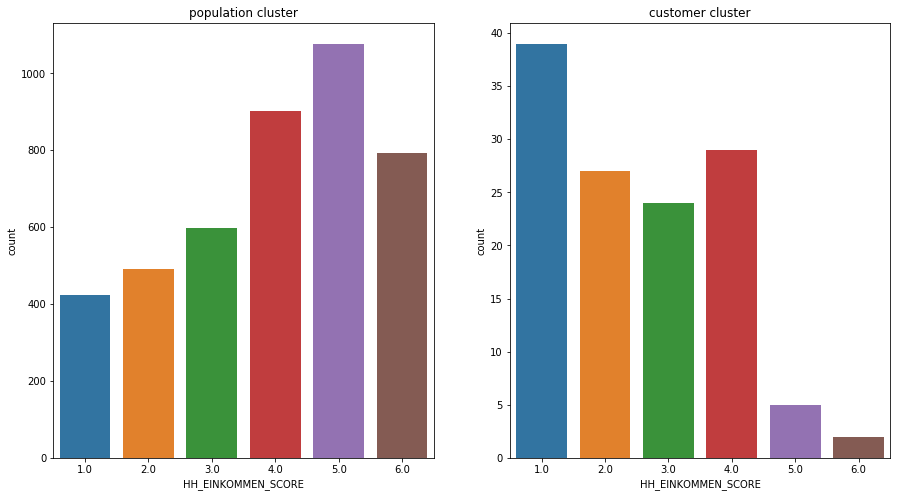

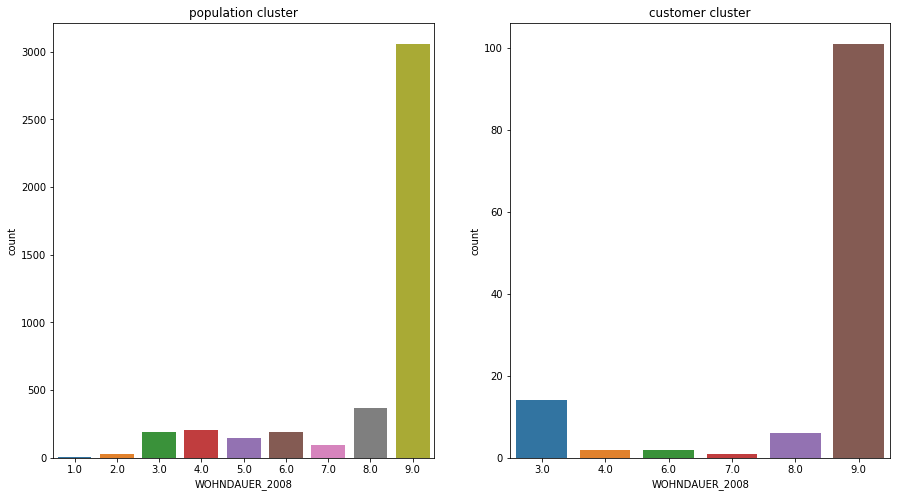

In [160]:
first_five_col=['ANREDE_KZ', 'FINANZTYP','HH_EINKOMMEN_SCORE','WOHNDAUER_2008']

for col in first_five_col:
    compare_datasets(col,pop_underrep,cust_underrep)

ANREDE_KZ:
-  1: male
-  2: female

FINANZTYP:
Most descriptive financial type for individual
-  1: low financial interest (MINIMALIST)
-  2: money-saver (SPARER)
-  3: home ownership (HAUSBAUER)
-  4: be prepared (VORSORGER)
-  5: investor (ANLEGER)
-  6: inconspicuous (UNAUFFAELLIGER)

HH_EINKOMMEN_SCORE
Estimated household net income

-  1: highest income
-  2: very high income
-  3: high income
-  4: average income
-  5: lower income
-  6: very low income

WOHNDAUER_2008:
Length of residence
-  1: length of residence less than 1 year
-  2: length of residence 1-2 years
-  3: length of residence 2-3 years
-  4: length of residence 3-4 years
-  5: length of residence 4-5 years
-  6: length of residence 5-6 years
-  7: length of residence 6-7 years
-  8: length of residence 7-10 years
-  9: length of residence more than 10 years

People that are part of the lowest cluster are: 
Mostly Male with financial type money savers,investors and inconspicuous, with estimated income ranging between highest and average household net income and who have stayed at a residence more than 10 years.

### Discussion 3.3: Compare Customer Data to Demographics Data

People that are part of the highest cluster are: 
Either male or female with financial type be prepared, with estimated very high household net income and people who have stayed at a residence between 8 to 9 years.


People that are part of the lowest cluster are: 
Mostly Male with financial type money savers,investors and inconspicuous, with estimated income ranging between highest and average household net income and who have stayed at a residence more than 10 years.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.